## Bonn Database Analysis

#### Importing Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from scipy.signal import welch, butter, filtfilt, decimate

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

os.environ["KERAS_BACKEND"] = "torch"

from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Normalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Nadam
from keras import backend as K

import torch

#### Importing data from the Bonn Database

In [3]:
# Defining classes/directories
directories = ['Z', 'O', 'N', 'F', 'S']
base_path = './bonn_database/'

# Initializing an auxiliar dictionary to store data
data_dict = {
# healthy volunteer data
    "Z": [],  # eyes open
    "O": [],  # eyes closed
# presurgical diagnosis data
    "N": [],  # not seizure - within the lesion area (hipocampus)
    "F": [],  # not seizure - within the other hemisphere's hipocampus
    "S": []   # seizure data
}

original_fs = 173.61 # sampling frequency

# Reading data from each directory
for dir_name in directories:
    dir_path = os.path.join(base_path, dir_name)
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        data = np.loadtxt(file_path)
        data_dict[dir_name].append(data)

# Convert lists to numpy ndarrays
for key in data_dict.keys():
    data_dict[key] = np.array(data_dict[key])

# Print shapes of data for verification
for key, value in data_dict.items():
    print(f" Data {key} shape: {value.shape}")

 Data Z shape: (100, 4097)
 Data O shape: (100, 4097)
 Data N shape: (100, 4097)
 Data F shape: (100, 4097)
 Data S shape: (100, 4097)


#### Filtering and downsampling the data

In [4]:
# defines the filter to be used
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [5]:
# filtering step
lowcut = 0.5
highcut = 40
down_factor = 2 # downsampling factor

filt_dict = {key: decimate(bandpass_filter(data, lowcut, highcut, original_fs), down_factor)
             for key, data in data_dict.items()}

fs = original_fs / down_factor

### Visualizing the EEG's and their spectrum

This is important so we can see the 2 features we are working with:
- The EEG's (raw, time-based data)
- The spectrum of the EEG's (frequency domain data)

In [6]:
# calculates the power spectral density for each data
psd_dict = {}

frequencies = []

for key, item in filt_dict.items():
    frequencies, psd_dict[key] = welch(item, fs=fs, nperseg=256)

print(f"PSD Z shape: {psd_dict["Z"].shape}")
# print(frequencies) # 0-43 Hz, near Nyquist frequency


PSD Z shape: (100, 129)


#### Plotting Samples

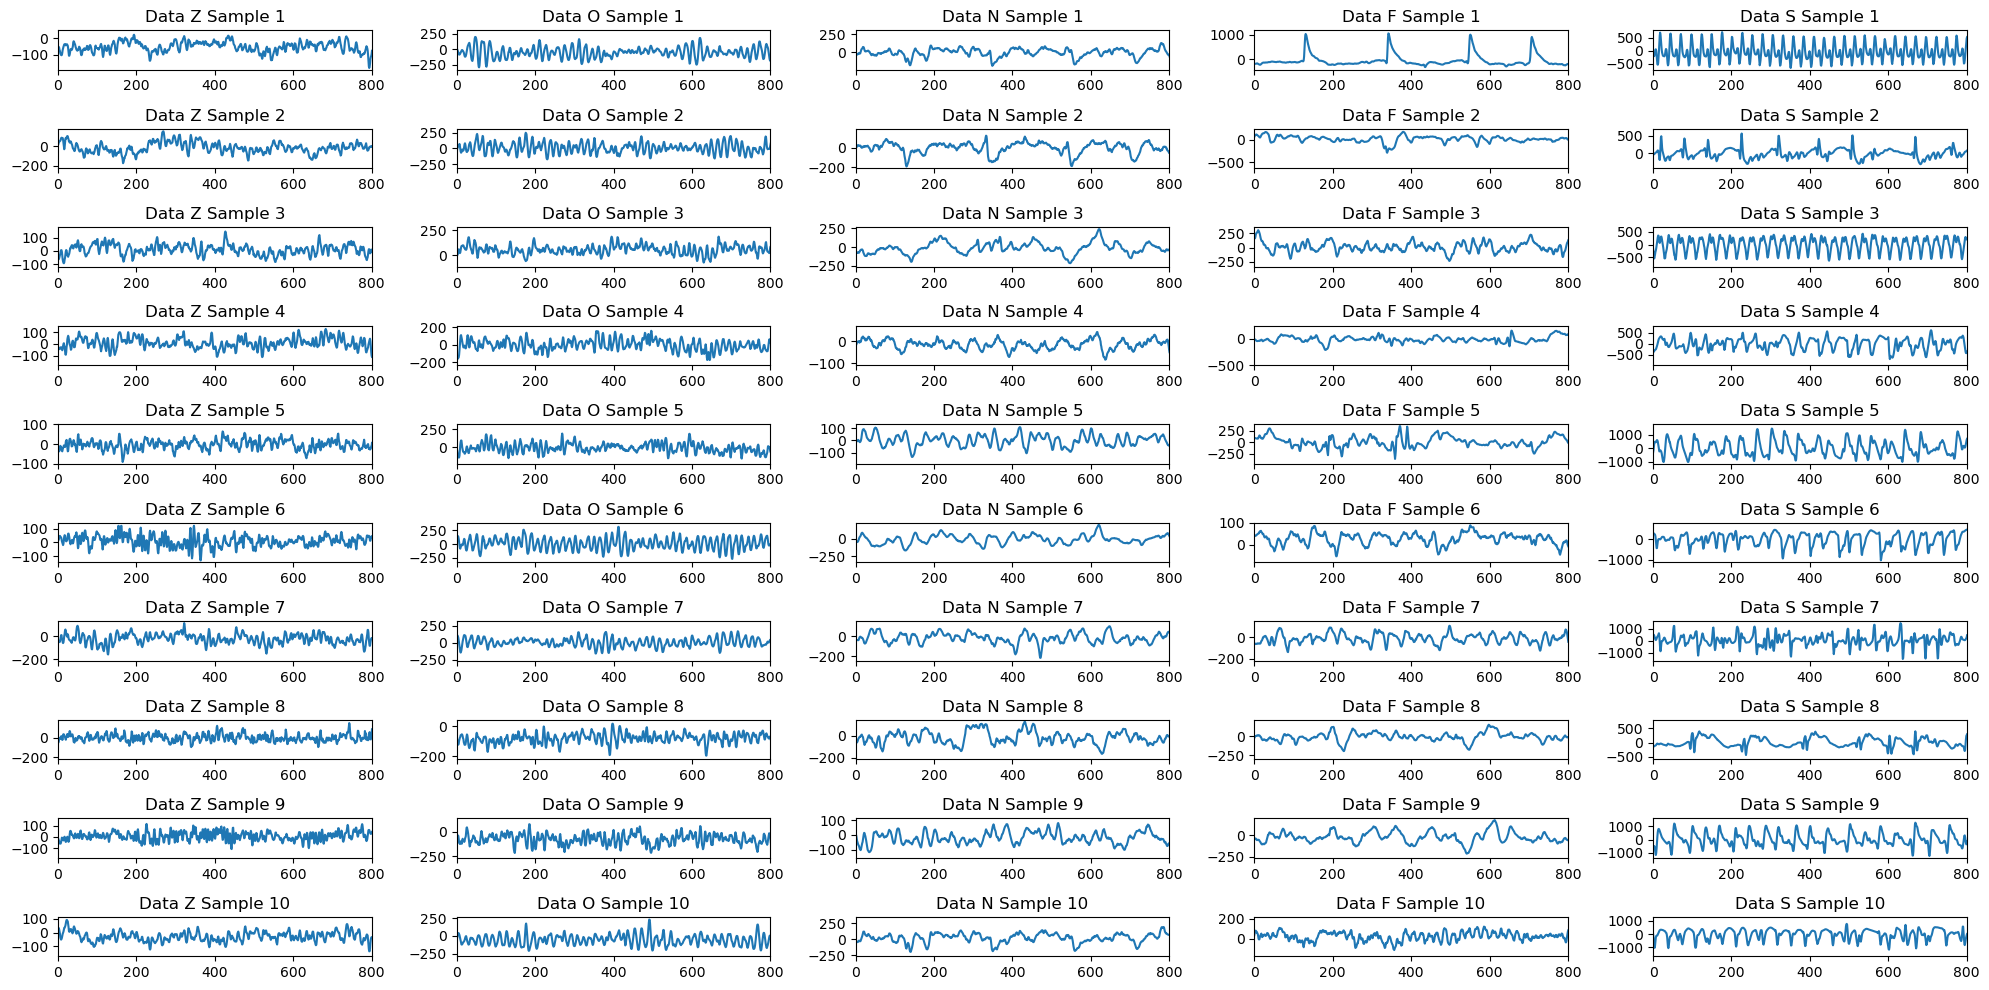

In [7]:
samples_to_plot = 10

# also plot the data in the time domain
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot time domain data for each dataset
for i in range(samples_to_plot):
    for col, class_name in enumerate(data_dict.keys()):
        axs[i, col].plot(data_dict[class_name][i])
        axs[i, col].set_xlim(0, 800)
        axs[i, col].set_title(f'Data {class_name} Sample {i+1}')

plt.tight_layout()
plt.show()

#### Plotting FFT's

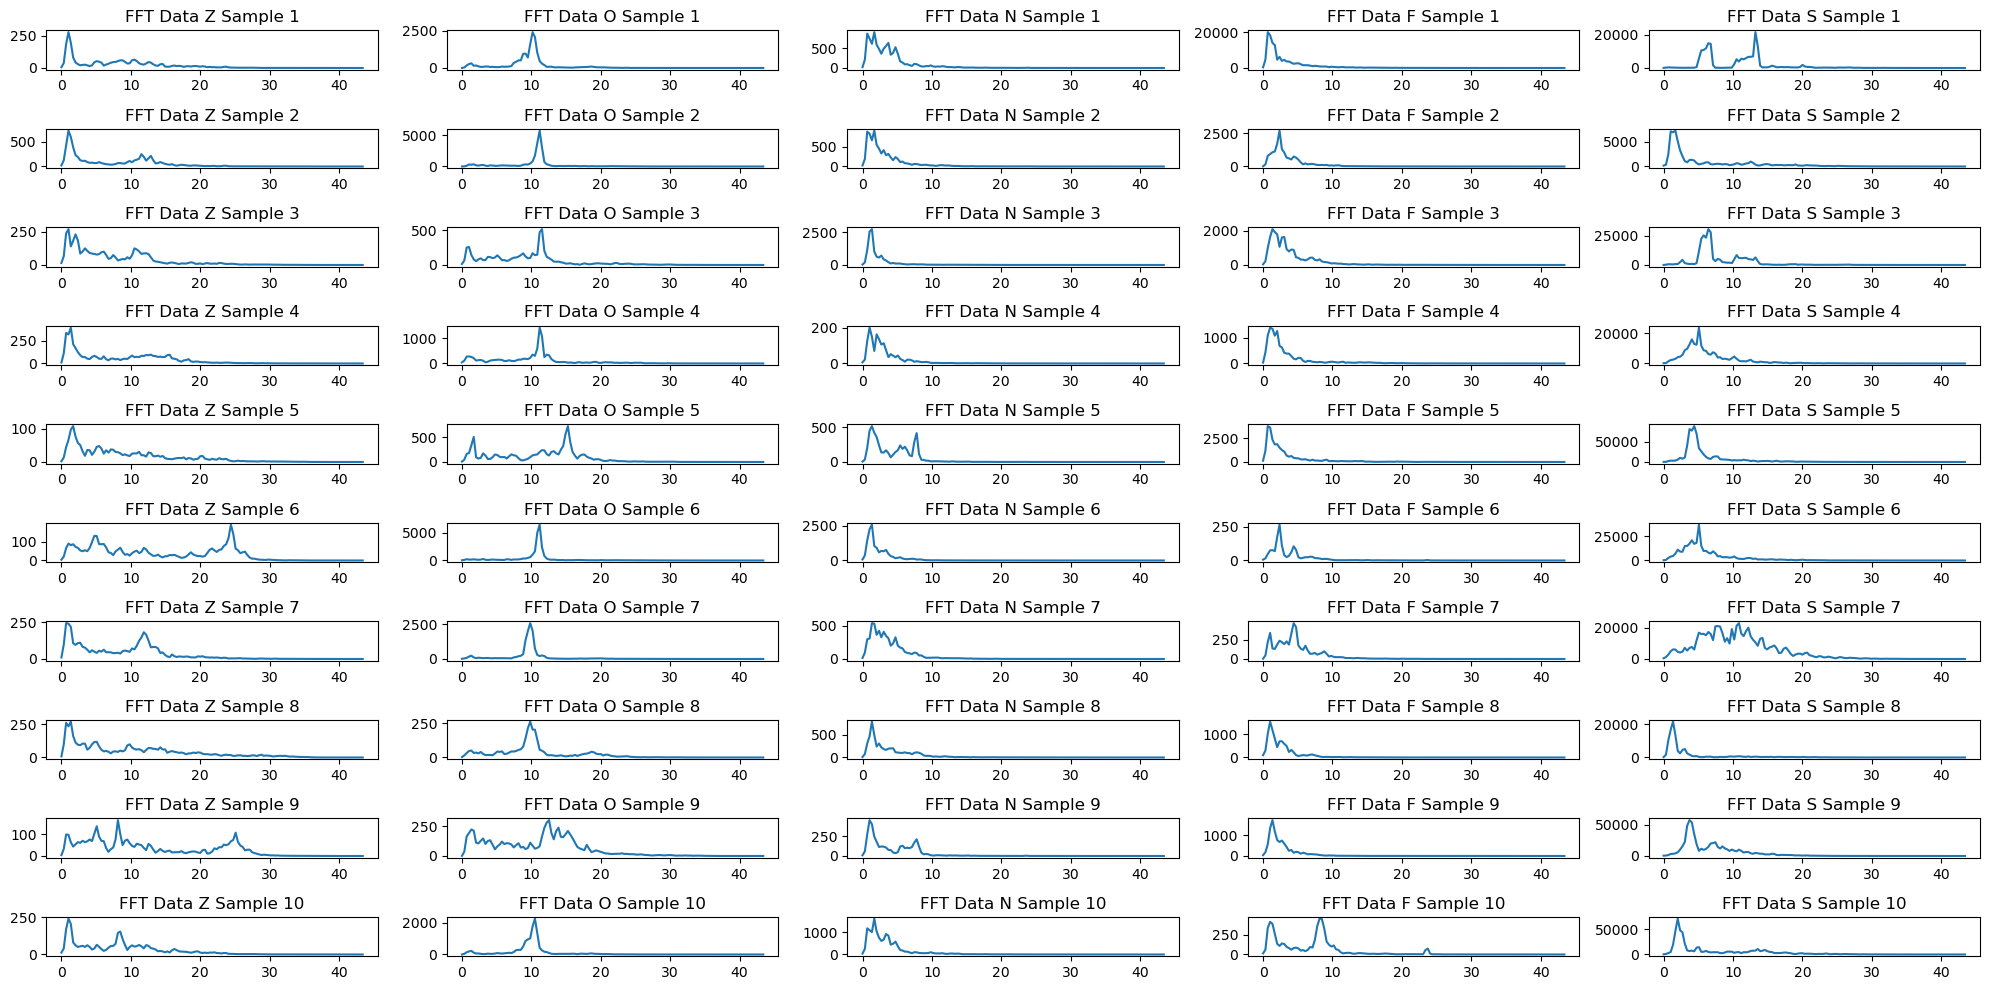

In [8]:
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot FFTs for each dataset
for i in range(samples_to_plot):
    for col, class_name in enumerate(data_dict.keys()):
        axs[i, col].plot(frequencies, psd_dict[class_name][i])
        axs[i, col].set_title(f'FFT Data {class_name} Sample {i+1}')

# Adjust layout
plt.tight_layout()
plt.show()

### Feature engineering
The main features i aim to extract are:

- the power of the EEG on each of the main literature frequency bands (delta, theta, alpha, beta, gamma);
- and the relative power of each of these bands;

Maybe i will also try to extract some other features like the Hjorth parameters, the fractal dimension and the entropy...

In [9]:
def band_power(frequencies, psd, band):
    """ Calcula a potência dentro de uma banda de frequência específica """
    band_idx = np.logical_and(frequencies >= band[0], frequencies <= band[1])  
    return np.trapz(psd[band_idx], frequencies[band_idx])

bands = { # f
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 40)
}

band_powers_df_dict = {}

for key, psd_list in psd_dict.items():
    band_powers_df_dict[key] = pd.DataFrame(
        {band: [band_power(frequencies, psd, bands[band]) for psd in psd_list] for band in bands}
        )

# print(band_powers_df_dict["Z"].shape) # (100, 5), 5 band powers per sample (100 samples)

In [10]:
norm_band_powers_df_dict = {}

for key, band_powers_df in band_powers_df_dict.items():
    norm_band_powers_df_dict[key] = band_powers_df.div(band_powers_df.sum(axis=1), axis=0)

# print(norm_band_powers_df_dict["Z"].shape) # (100, 5), 5 band powers per sample (100 samples)

#### Visualizing the features on a 3d point cloud

In [11]:
import plotly.express as px
import pandas as pd

# combining data onto single df (plotly express requirement)
all_classes_df = pd.concat([
    band_powers_df.assign(Class=key) for key, band_powers_df in band_powers_df_dict.items()
])

classes_to_be_plotted = ["Delta", "Alpha", "Beta"]

# scatter matrix instead of 3d scatter plot
fig = px.scatter_matrix(
    all_classes_df,
    dimensions = bands.keys(),
    color='Class',  # Color by class
    title='3D Scatter Plot of Band Powers',
    # labels={'Delta': 'Delta Power', 'Theta': 'Theta Power', 'Alpha': 'Alpha Power'}
)

fig.show()

### Constructing classifiers based on the 4 different feature sets

#### Separating data between train and test

In [12]:
time_data = {
    key: data for key, data in filt_dict.items()
}

frequency_data = {
    key: psd for key, psd in psd_dict.items()
}

band_power_data = {
    key: band_powers_df for key, band_powers_df in band_powers_df_dict.items()
}

normalized_band_power_data = {
    key: norm_band_powers_df for key, norm_band_powers_df in norm_band_powers_df_dict.items()
}

# split data in dict's into train and test sets
def split_data(data_dict, test_size=0.2, random_state=42):
    X = []
    y = []
    for label, data in data_dict.items():
        X.append(data)
        y.extend([label] * len(data))
    X = np.vstack(X)
    y = np.array(y)
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# splitting data into train and test sets
X_train_time, X_test_time, y_train_time, y_test_time = split_data(time_data)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = split_data(frequency_data)
X_train_band, X_test_band, y_train_band, y_test_band = split_data(band_power_data)
X_train_norm_band, X_test_norm_band, y_train_norm_band, y_test_norm_band = split_data(normalized_band_power_data)

# printing shapes for berification
print("Time-domain data:", X_train_time.shape, X_test_time.shape)
print("Frequency-domain data:", X_train_freq.shape, X_test_freq.shape)
print("Band power data:", X_train_band.shape, X_test_band.shape)
print("Normalized band power data:", X_train_norm_band.shape, X_test_norm_band.shape)

Time-domain data: (400, 2049) (100, 2049)
Frequency-domain data: (400, 129) (100, 129)
Band power data: (400, 5) (100, 5)
Normalized band power data: (400, 5) (100, 5)


In [13]:
def dict_to_Xy(data_dict):
    X = []
    y = []
    for label, data in data_dict.items():
        X.append(data)
        y.extend([label] * len(data))
    return np.vstack(X), np.array(y)

##### Setting up a model gatherer dictionary for later analysis

In [14]:
models = {
    "MLP Time-Domain": {
        "X_test": X_test_time,
        "y_test": y_test_time,
        "model": None  # to be stored...
    },
    "MLP Frequency-Domain": {
        "X_test": X_test_freq,
        "y_test": y_test_freq,
        "model": None
    },
    "MLP Band Power": {
        "X_test": X_test_band,
        "y_test": y_test_band,
        "model": None
    },
    "MLP Normalized Band Power": {
        "X_test": X_test_norm_band,
        "y_test": y_test_norm_band,
        "model": None
    },
    "MLP Expanded Features": {
        "X_test": None,
        "y_test": None,
        "model": None
    },
    "CNN Time-Domain": {
        "X_test": X_test_time.reshape(X_test_time.shape[0], X_test_time.shape[1], 1),
        "y_test": y_test_time,
        "model": None
    },
    "CNN Frequency-Domain": {
        "X_test": X_test_freq.reshape(X_test_freq.shape[0], X_test_freq.shape[1], 1),
        "y_test": y_test_freq,
        "model": None
    }
}

#### Setting up aux functions

##### create generic mlp function

In [56]:
# Function to create a basic MLP model, given input and output dimensions
def create_mlp(input_dim, num_classes, verbose=0):
    model = Sequential([
        Input(shape=(input_dim,)),
        Normalization(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # (se quiser forçar GPU como default)
    if torch.cuda.is_available():
        try:
            model.to("cuda")
        except AttributeError:
            pass  # versões mais antigas do torch não têm set_default_device

    model.compile(
        optimizer='Nadam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    if verbose > 0:
        model.summary()

    return model

##### train and evaluate a given model

In [62]:
from typing import Dict, List, Union

Label = Union[int, str]
TaskSpec = Dict[str, Union[List[Label], str, List[List[Label]]]]

def encode_coarse_tasks(coarse_tasks: Dict[str, TaskSpec], class_names: List[str]):
    if not coarse_tasks:
        return None
    name_to_idx = {name: i for i, name in enumerate(class_names)}
    all_idx = set(name_to_idx.values())
    encoded = {}
    for tname, spec in coarse_tasks.items():
        if "groups" in spec:
            groups = []
            for g in spec["groups"]:
                groups.append([name_to_idx[c] if isinstance(c, str) else int(c) for c in g])
            encoded[tname] = {"groups": groups}
        else:
            pos = [name_to_idx[c] if isinstance(c, str) else int(c) for c in spec["positive"]]
            if "negative" in spec:
                if spec["negative"] == "rest":
                    neg = list(all_idx - set(pos))
                else:
                    neg = [name_to_idx[c] if isinstance(c, str) else int(c) for c in spec["negative"]]
            else:
                neg = list(all_idx - set(pos))
            encoded[tname] = {"pos": pos, "neg": neg}
    return encoded

def eval_encoded_tasks(y_true_enc: np.ndarray, proba: np.ndarray, encoded_tasks: Dict[str, dict]):
    if not encoded_tasks:
        return {}
    out = {}
    for tname, spec in encoded_tasks.items():
        if "groups" in spec:  # multi-grupo
            group_probs = np.stack([proba[:, g].sum(axis=1) for g in spec["groups"]], axis=1)
            y_pred_group = group_probs.argmax(axis=1)
            class_to_group = np.full(proba.shape[1], -1, dtype=int)
            for gid, g in enumerate(spec["groups"]):
                class_to_group[g] = gid
            y_true_group = class_to_group[y_true_enc]
            out[tname] = {
                "acc": float(accuracy_score(y_true_group, y_pred_group)),
                "f1": float(f1_score(y_true_group, y_pred_group, average="weighted")),
                "recall": float(recall_score(y_true_group, y_pred_group, average="weighted")),
                "precision": float(precision_score(y_true_group, y_pred_group, average="weighted")),
            }
        else:  # binária
            p_pos = proba[:, spec["pos"]].sum(axis=1)
            y_true_bin = np.isin(y_true_enc, spec["pos"]).astype(int)
            y_pred_bin = (p_pos >= 0.5).astype(int)
            mdict = {
                "acc": float(accuracy_score(y_true_bin, y_pred_bin)),
                "precision": float(precision_score(y_true_bin, y_pred_bin, zero_division=0)),
                "recall": float(recall_score(y_true_bin, y_pred_bin, zero_division=0)),
                "f1": float(f1_score(y_true_bin, y_pred_bin, zero_division=0)),
            }
            out[tname] = mdict
    return out

coarse_tasks = {
    # Binária: positivo = {Z,O}, negativo = resto
    "Healthy vs Unhealthy": {"positive": ["Z", "O"]},

    # Binária: positivo = {E}, negativo = {A,B,C,D}
    "Seizure vs Non-Seizure": {"positive": ["S"], "negative": ["Z","O","N","F"]},

    # Multigrupo: 2+ grupos
    "N-I vs I-I vs I": {"groups": [["Z", "O"], ["N","F"], ["S"]]},
}

In [63]:
def train_and_evaluate(
        model,
        X_train, y_train_encoded,
        X_test, y_test_encoded,
        num_classes,
        epochs=200,
        batch_size=8,
        verbose=1,
        patience=15,
        min_delta=0.001,
):
    # One-hot
    y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
    y_test_categorical  = to_categorical(y_test_encoded,  num_classes=num_classes)

    # Adaptar camada Normalization (procura pela camada ao invés de index fixo)
    for layer in model.layers:
        if isinstance(layer, Normalization):
            layer.adapt(np.asarray(X_train, dtype='float32'))
            break

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        mode='min',
        restore_best_weights=True,
        verbose=1 if verbose else 0,
    )

    history = model.fit(
        X_train, y_train_categorical,
        epochs=epochs,
        batch_size=batch_size,
        # verbose=verbose,
        validation_data=(X_test, y_test_categorical),
        callbacks=[early_stopping]
    )

    proba  = model.predict(X_test, verbose=0)
    y_pred = proba.argmax(axis=1)

    # Métricas do fold (weighted mantém efeito de suporte por classe)
    acc    = float(accuracy_score(y_test_encoded, y_pred))
    prec   = float(precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0))
    f1m    = float(f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0))
    recall = float(recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0))

    metrics = {"acc": acc, "f1": f1m, "precision": prec, "recall": recall}
    return model, history, metrics, y_pred, proba


##### function to display results

In [59]:
def display_training_results(
        model,
        X_test, y_test_encoded,
        history,
        feature_name,
        class_names
):
    num_classes = len(class_names)
    y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)
    print(f"{feature_name} - Test Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    proba = model.predict(X_test) # probabilities
    y_pred = proba.argmax(axis=1) # predicted classes (encoded)
    print(classification_report(y_test_encoded, y_pred, target_names=class_names, digits=3))

    # figure for accuracy and loss plots
    plt.figure(figsize=(20, 6))

    # plotting accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{feature_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # plotting loss too
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{feature_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # plotting the confusion matrix
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_test_encoded, y_pred)

    # Normalize confusion matrix (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot with seaborn for better visualization
    ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{feature_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.tight_layout()
    plt.show()

##### k-fold function

In [60]:
def _effective_input_shape(model):
    ish = model.input_shape
    if isinstance(ish, (list, tuple)) and len(ish) > 0 and isinstance(ish[0], (list, tuple)):
        ish = ish[0]
    return ish  # e.g., (None, D) ou (None, T, C)

def _reshape_for_model_if_needed(X, input_shape):
    X = np.asarray(X, dtype='float32')
    if input_shape is None:
        return X
    rank = len(input_shape)
    if rank == 3:  # (None, T, C)
        if X.ndim == 2:
            return X.reshape((X.shape[0], X.shape[1], 1)).astype('float32')
        return X
    if rank == 2:  # (None, D)
        if X.ndim == 3 and X.shape[2] == 1:
            return X.reshape((X.shape[0], X.shape[1])).astype('float32')
        return X
    return X

def do_kfold(
    create_model,
    X, y,
    coarse_tasks=None,
    n_splits=5,
    random_state=42,
    stratify=True,
    epochs=200,
    batch_size=8,
    verbose=0,
    feature_name="MLP",
):
    X = np.asarray(X)
    y = np.asarray(y)

    # encoder global
    enc = LabelEncoder()
    y_encoded = enc.fit_transform(y)
    class_names = list(enc.classes_)
    num_classes = len(class_names)

    # codifica tasks uma ÚNICA vez por nomes -> índices
    encoded_tasks = encode_coarse_tasks(coarse_tasks, class_names) if coarse_tasks else None

    splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state) if stratify \
               else KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_results = []
    oof_pred = np.empty_like(y_encoded)
    histories = []

    for fold, (tr_idx, val_idx) in enumerate(splitter.split(X, y_encoded if stratify else None), 1):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y_encoded[tr_idx], y_encoded[val_idx]

        # novo modelo limpo por fold
        K.clear_session()
        model = create_model(X_tr.shape[1], num_classes, verbose=verbose)

        # Reshape automático conforme o input do modelo (MLP 2D vs CNN1D 3D)
        ish = _effective_input_shape(model)  # (None, D) ou (None, T, C)
        X_tr = _reshape_for_model_if_needed(X_tr, ish)
        X_val = _reshape_for_model_if_needed(X_val, ish)

        model, history, metrics, y_hat, proba = train_and_evaluate(
            model,
            X_tr, y_tr,
            X_val, y_val,
            num_classes,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose
        )

        # métricas das coarse tasks (se houver)
        if encoded_tasks:
            task_metrics = eval_encoded_tasks(y_val, proba, encoded_tasks)
            for tname, mdict in task_metrics.items():
                for mk, mv in mdict.items():
                    metrics[f"task:{tname}/{mk}"] = float(mv)

        fold_results.append({"fold": fold, **metrics})

        histories.append(history)
        oof_pred[val_idx] = y_hat

        # Quando verbose == 2, mostramos curvas e matriz de confusão deste fold
        if verbose == 2:
            display_training_results(
                model,
                X_val,
                y_val,
                history,
                feature_name=f"{feature_name} (fold {fold})",
                class_names=class_names,
            )

    # agregação: média/DP para TODAS as chaves numéricas (inclui tasks)
    numeric_keys = sorted({
        k for fr in fold_results for k, v in fr.items()
        if k != "fold" and isinstance(v, (int, float, np.floating))
    })

    summary = {}
    for k in numeric_keys:
        vals = [fr[k] for fr in fold_results if k in fr]
        summary[k + "_mean"] = float(np.mean(vals))
        summary[k + "_std"]  = float(np.std(vals))

    # Construção de resumo por coarse task (médias/DP por métrica)
    task_summary = {}
    for k in numeric_keys:
        if k.startswith("task:"):
            try:
                rest = k.split("task:", 1)[1]
                tname, mk = rest.split("/", 1)
            except Exception:
                continue
            task_summary.setdefault(tname, {})[mk] = (
                summary.get(k + "_mean", float('nan')),
                summary.get(k + "_std", float('nan')),
            )

    # Logs principais (se existirem as chaves base)
    def _pget(fr, k):
        return fr.get(k, float('nan'))

    base_keys = ("acc", "f1", "precision", "recall")
    if all(any(k in fr for fr in fold_results) for k in base_keys):
        print(f"=== {feature_name} | {n_splits}-fold CV ===")
        for fr in fold_results:
            print(
                f"Fold {fr['fold']}: "
                f"acc={_pget(fr,'acc'):.4f} | f1={_pget(fr,'f1'):.4f} | "
                f"P={_pget(fr,'precision'):.4f} | R={_pget(fr,'recall'):.4f}"
            )
        print(
            f"Média±DP  acc: {summary.get('acc_mean', float('nan')):.4f} ± {summary.get('acc_std', float('nan')):.4f}\n"
            f"Média±DP   f1: {summary.get('f1_mean', float('nan')):.4f} ± {summary.get('f1_std', float('nan')):.4f}\n"
            f"Média±DP prec: {summary.get('precision_mean', float('nan')):.4f} ± {summary.get('precision_std', float('nan')):.4f}\n"
            f"Média±DP  rec: {summary.get('recall_mean', float('nan')):.4f} ± {summary.get('recall_std', float('nan')):.4f}"
        )

    # Resumo das coarse tasks (média ± DP)
    if task_summary:
        print("--- Coarse tasks (média ± DP) ---")
        for tname in sorted(task_summary.keys()):
            print(f"{tname}:")
            for mk in sorted(task_summary[tname].keys()):
                mu, sd = task_summary[tname][mk]
                if np.isnan(mu) or np.isnan(sd):
                    continue
                print(f"  {mk}: {mu:.4f} ± {sd:.4f}")

    return {
        "fold_results": fold_results,
        "summary": summary,         # inclui médias/DP de tasks
        "oof_pred": oof_pred,
        "encoder": enc,
        "histories": histories,
        "class_names": class_names,
        "encoded_tasks": encoded_tasks,
        "task_summary": task_summary,
    }

#### Training the MLP's

##### time-based MLP

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049)           │         4,099 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,704 (553.53 KB)

 Trainable params: 137,605 (537.52 KB)

 Non-trainable params: 4,099 (16.01 KB)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2204 - loss: 2.0110 - val_accuracy: 0.2600 - val_loss: 1.4842
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2806 - loss: 1.4848 - val_accuracy: 0.3600 - val_loss: 1.4012
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2783 - loss: 1.4004 - val_accuracy: 0.5000 - val_loss: 1.3485
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3797 - loss: 1.3347 - val_accuracy: 0.5200 - val_loss: 1.3287
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4710 - loss: 1.2132 - val_accuracy: 0.5800 - val_loss: 1.3201
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5226 - loss: 1.1700 - val_accuracy: 0.5400 - val_loss: 1.3129
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6183 - loss: 1.1888 - val_accuracy: 0.5600 - val_loss: 1.2944
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5814 - loss: 1.0561 - val_accuracy: 0.6400 - v

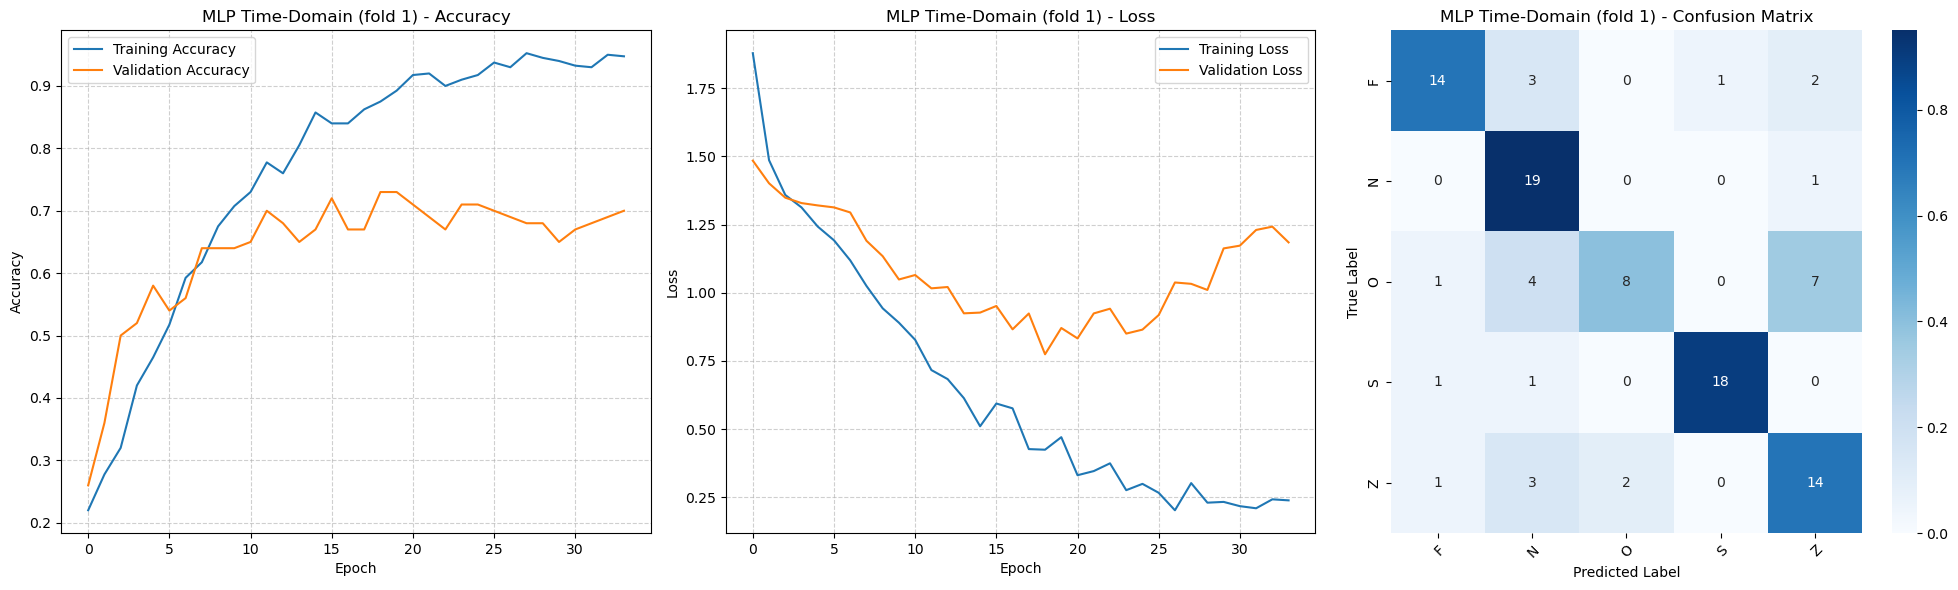

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049)           │         4,099 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,704 (553.53 KB)

 Trainable params: 137,605 (537.52 KB)

 Non-trainable params: 4,099 (16.01 KB)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2215 - loss: 1.7310 - val_accuracy: 0.4500 - val_loss: 1.4033
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3411 - loss: 1.4553 - val_accuracy: 0.4300 - val_loss: 1.3969
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4008 - loss: 1.4151 - val_accuracy: 0.5500 - val_loss: 1.3826
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4683 - loss: 1.2838 - val_accuracy: 0.4800 - val_loss: 1.3295
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5339 - loss: 1.2142 - val_accuracy: 0.4900 - val_loss: 1.2863
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5672 - loss: 1.0849 - val_accuracy: 0.5100 - val_loss: 1.2180
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5731 - loss: 1.0126 - val_accuracy: 0.5500 - val_loss: 1.1757
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6085 - loss: 1.0323 - val_accuracy: 0.5500 - v

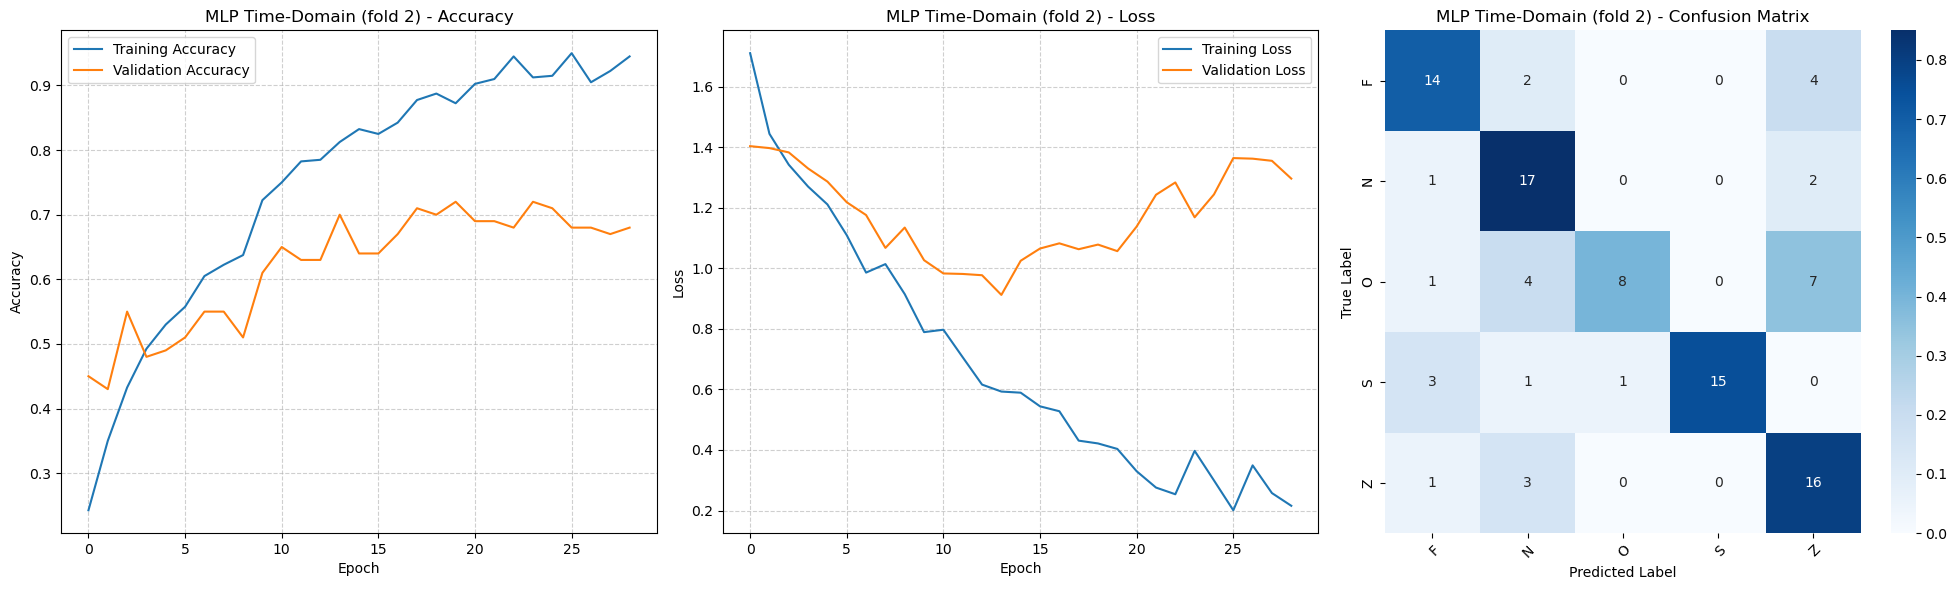

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049)           │         4,099 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,704 (553.53 KB)

 Trainable params: 137,605 (537.52 KB)

 Non-trainable params: 4,099 (16.01 KB)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2119 - loss: 1.8681 - val_accuracy: 0.2700 - val_loss: 1.4409
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2905 - loss: 1.4749 - val_accuracy: 0.4400 - val_loss: 1.3713
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3266 - loss: 1.3773 - val_accuracy: 0.5000 - val_loss: 1.3037
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4133 - loss: 1.3030 - val_accuracy: 0.5400 - val_loss: 1.2459
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4679 - loss: 1.2323 - val_accuracy: 0.5300 - val_loss: 1.2014
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5418 - loss: 1.1283 - val_accuracy: 0.6500 - val_loss: 1.1318
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6171 - loss: 1.0197 - val_accuracy: 0.6500 - val_loss: 1.1081
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6912 - loss: 0.9446 - val_accuracy: 0.6500 - v

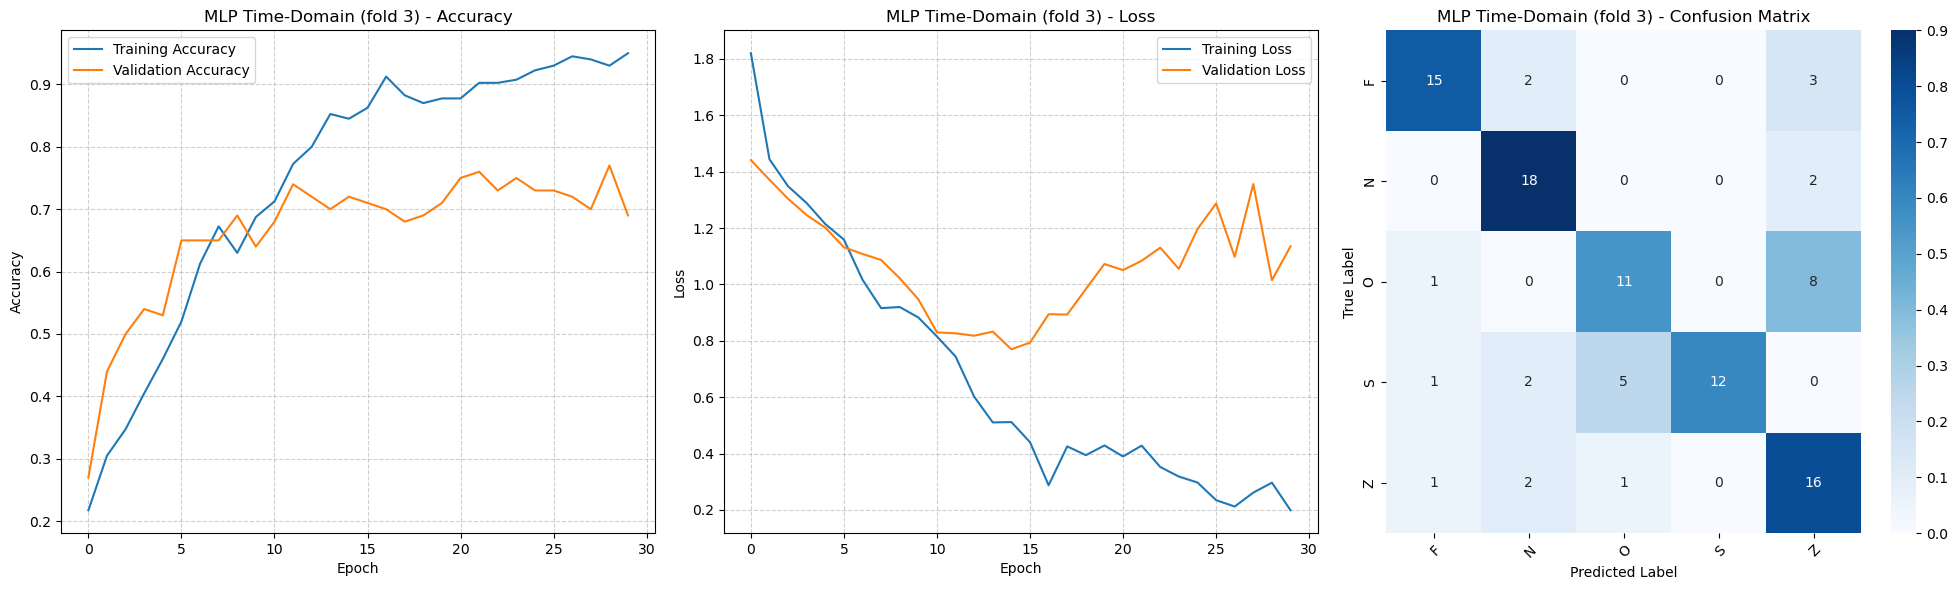

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049)           │         4,099 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,704 (553.53 KB)

 Trainable params: 137,605 (537.52 KB)

 Non-trainable params: 4,099 (16.01 KB)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2147 - loss: 2.0900 - val_accuracy: 0.2900 - val_loss: 1.4290
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3012 - loss: 1.5697 - val_accuracy: 0.3600 - val_loss: 1.3289
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3907 - loss: 1.3981 - val_accuracy: 0.4300 - val_loss: 1.3049
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4085 - loss: 1.2962 - val_accuracy: 0.4700 - val_loss: 1.2486
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4554 - loss: 1.2700 - val_accuracy: 0.5300 - val_loss: 1.2041
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4948 - loss: 1.1816 - val_accuracy: 0.5800 - val_loss: 1.1859
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5115 - loss: 1.1715 - val_accuracy: 0.5900 - val_loss: 1.1296
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5581 - loss: 1.1368 - val_accuracy: 0.6400 - v

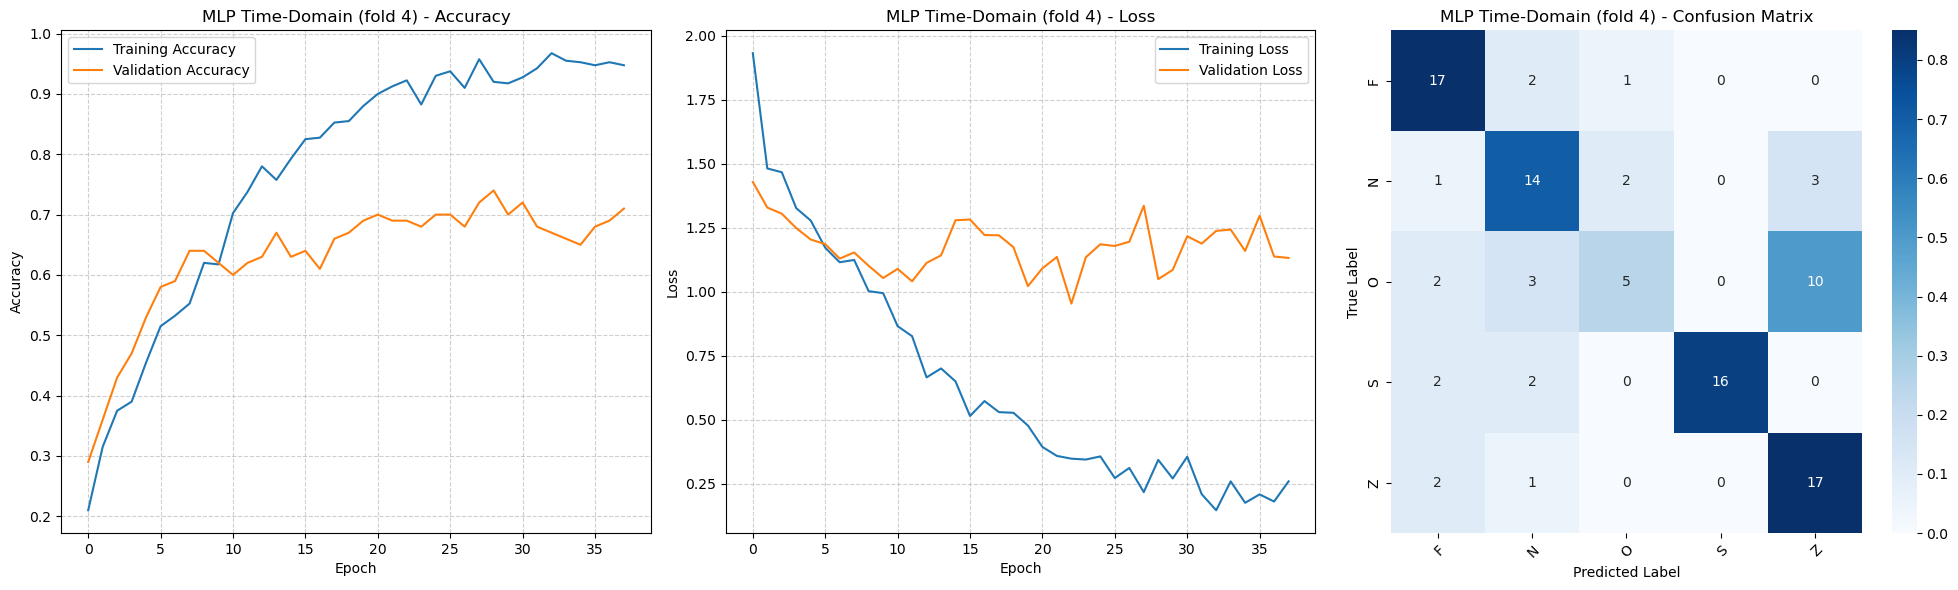

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049)           │         4,099 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,704 (553.53 KB)

 Trainable params: 137,605 (537.52 KB)

 Non-trainable params: 4,099 (16.01 KB)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2036 - loss: 1.9750 - val_accuracy: 0.3100 - val_loss: 1.4197
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3528 - loss: 1.5350 - val_accuracy: 0.4300 - val_loss: 1.3410
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3649 - loss: 1.3824 - val_accuracy: 0.5000 - val_loss: 1.2944
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4207 - loss: 1.3601 - val_accuracy: 0.5500 - val_loss: 1.2272
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4963 - loss: 1.2913 - val_accuracy: 0.5600 - val_loss: 1.1480
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5421 - loss: 1.1782 - val_accuracy: 0.6300 - val_loss: 1.0967
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5349 - loss: 1.0682 - val_accuracy: 0.6500 - val_loss: 1.0338
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5818 - loss: 1.0243 - val_accuracy: 0.6600 - v

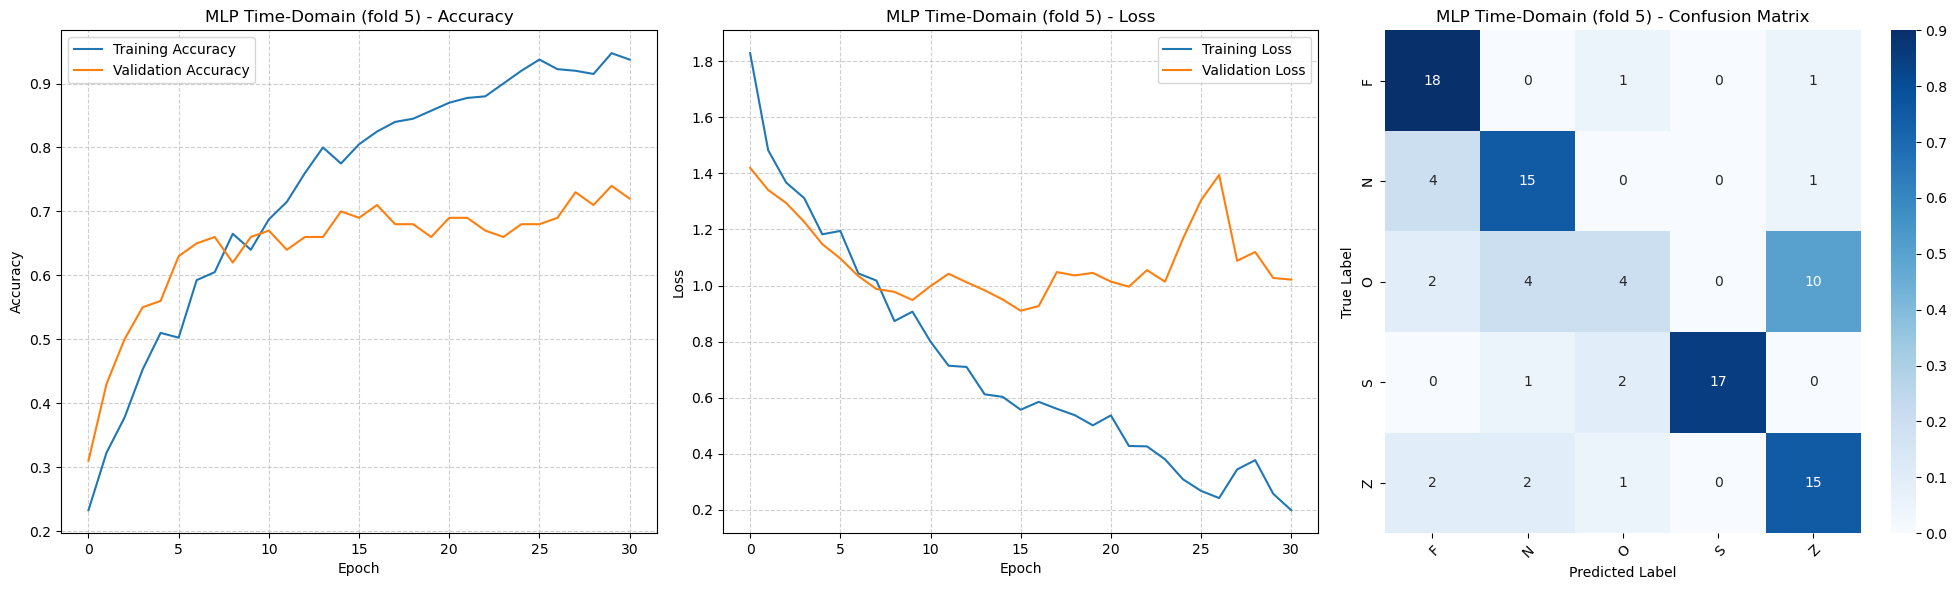

=== MLP Time-Domain | 5-fold CV ===
Fold 1: acc=0.7300 | f1=0.7219 | P=0.7575 | R=0.7300
Fold 2: acc=0.7000 | f1=0.6971 | P=0.7540 | R=0.7000
Fold 3: acc=0.7200 | f1=0.7211 | P=0.7564 | R=0.7200
Fold 4: acc=0.6900 | f1=0.6731 | P=0.7073 | R=0.6900
Fold 5: acc=0.6900 | f1=0.6680 | P=0.6859 | R=0.6900
Média±DP  acc: 0.7060 ± 0.0162
Média±DP   f1: 0.6962 ± 0.0229
Média±DP prec: 0.7322 ± 0.0299
Média±DP  rec: 0.7060 ± 0.0162
--- Coarse tasks (média ± DP) ---
Healthy vs Unhealthy:
  acc: 0.8680 ± 0.0194
  f1: 0.8307 ± 0.0242
  precision: 0.8563 ± 0.0441
  recall: 0.8100 ± 0.0464
N-I vs I-I vs I:
  acc: 0.8260 ± 0.0320
  f1: 0.8258 ± 0.0331
  precision: 0.8391 ± 0.0260
  recall: 0.8260 ± 0.0320
Seizure vs Non-Seizure:
  acc: 0.9480 ± 0.0240
  f1: 0.8457 ± 0.0837
  precision: 0.9895 ± 0.0211
  recall: 0.7500 ± 0.1304


In [64]:
X_time, y_time = dict_to_Xy(time_data)

results = do_kfold(
    create_model=create_mlp,
    X=X_time,
    y=y_time,
    n_splits=5,
    random_state=42,
    stratify=True,
    epochs=200,
    batch_size=8,
    verbose=2,
    feature_name="MLP Time-Domain",
    coarse_tasks=coarse_tasks
)
# print(results["summary"])
# models["MLP Time-Domain"]["model"] = model

##### frequency-based MLP

In [ ]:
X_freq, y_freq = dict_to_Xy(frequency_data)
results = do_kfold(
    create_model=create_mlp,
    X=X_freq,
    y=y_freq,
    n_splits=5,
    random_state=42,
    stratify=True,
    epochs=200,
    batch_size=8,
    verbose=2,
    feature_name="MLP Freq-Domain",
    coarse_tasks=coarse_tasks
)

# model, _ = train_and_evaluate(X_train_freq, X_test_freq, y_train_freq, y_test_freq, "Frequency-domain data")
# models["MLP Frequency-Domain"]["model"] = model

##### Band Power MLP

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,800 (26.56 KB)

 Trainable params: 6,789 (26.52 KB)

 Non-trainable params: 11 (44.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2284 - loss: 1.6050 - val_accuracy: 0.3900 - val_loss: 1.4487
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3616 - loss: 1.4737 - val_accuracy: 0.3800 - val_loss: 1.3762
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3860 - loss: 1.3620 - val_accuracy: 0.3800 - val_loss: 1.3190
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4268 - loss: 1.3293 - val_accuracy: 0.3900 - val_loss: 1.2765
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4359 - loss: 1.2348 - val_accuracy: 0.4000 - val_loss: 1.2314
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4498 - loss: 1.2355 - val_accuracy: 0.4000 - val_loss: 1.1961
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4418 - loss: 1.2095 - val_accuracy: 0.4100 - val_loss: 1.1657
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3841 - loss: 1.2262 - val_accuracy: 0.4600 - v

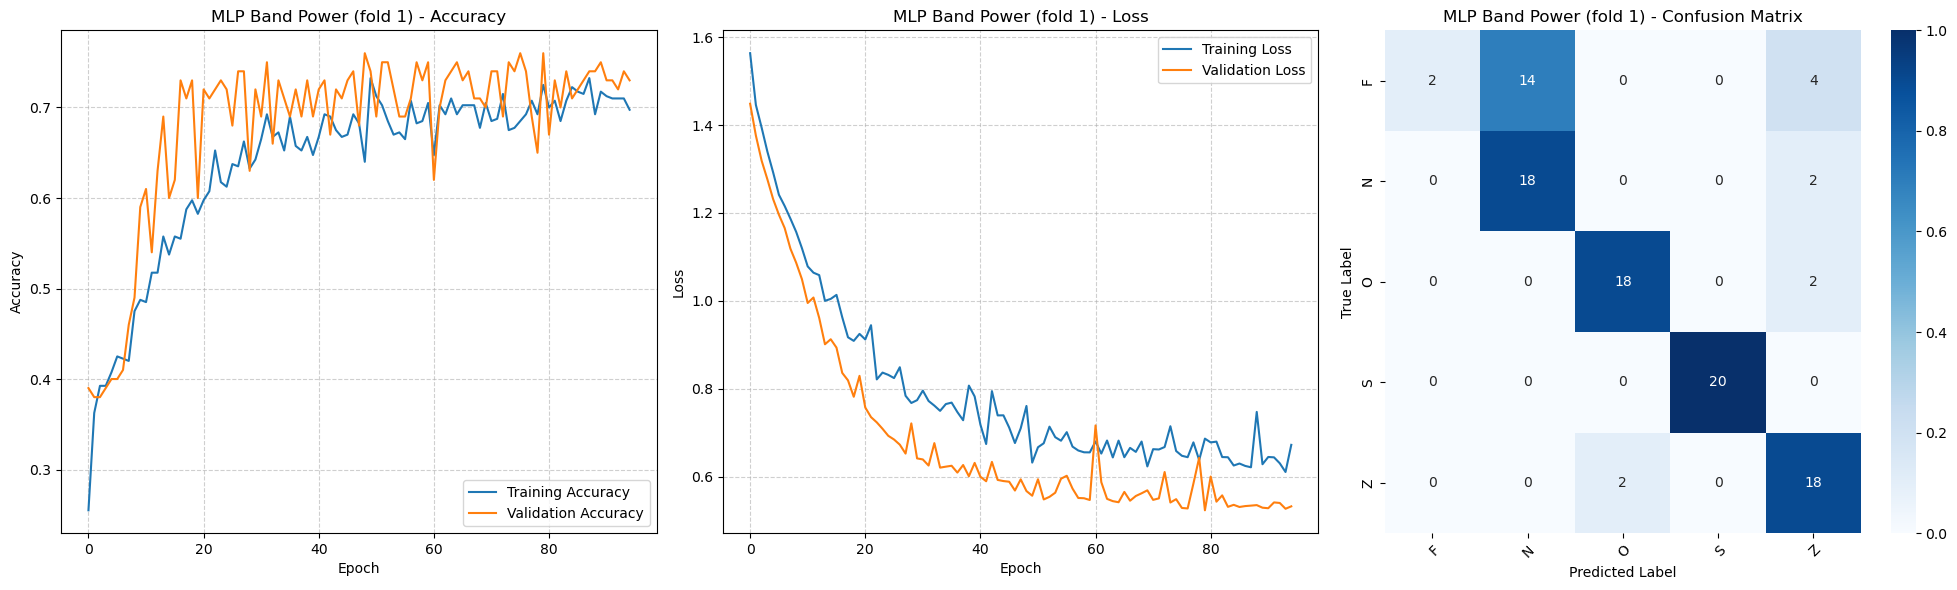

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,800 (26.56 KB)

 Trainable params: 6,789 (26.52 KB)

 Non-trainable params: 11 (44.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2828 - loss: 1.6298 - val_accuracy: 0.3500 - val_loss: 1.5425
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3366 - loss: 1.4970 - val_accuracy: 0.4000 - val_loss: 1.4776
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3845 - loss: 1.4145 - val_accuracy: 0.3800 - val_loss: 1.4262
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4052 - loss: 1.3289 - val_accuracy: 0.5200 - val_loss: 1.3671
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3868 - loss: 1.3258 - val_accuracy: 0.4900 - val_loss: 1.3209
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3966 - loss: 1.3239 - val_accuracy: 0.5500 - val_loss: 1.2641
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4220 - loss: 1.2823 - val_accuracy: 0.4800 - val_loss: 1.2146
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4221 - loss: 1.2302 - val_accuracy: 0.5300 - v

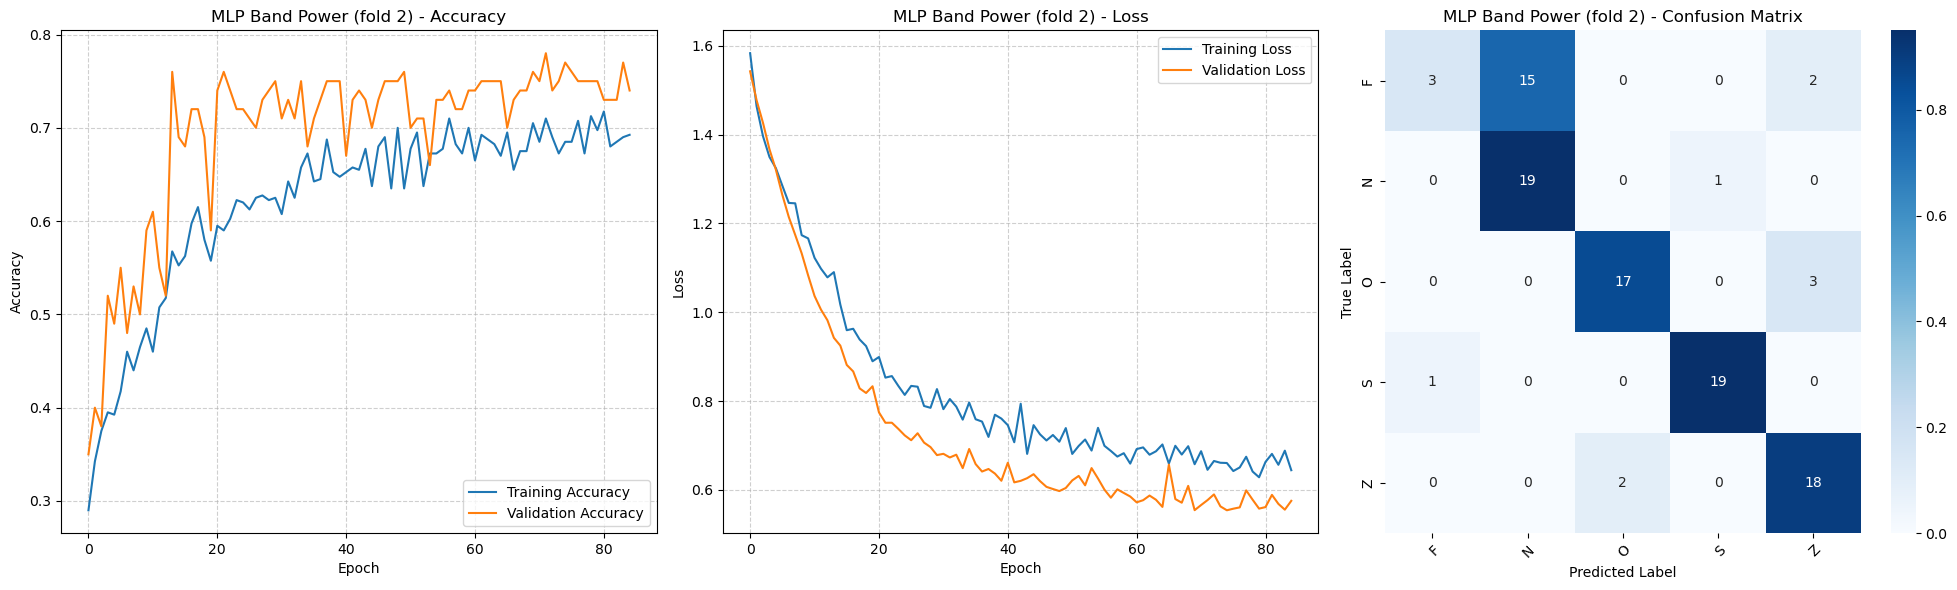

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,800 (26.56 KB)

 Trainable params: 6,789 (26.52 KB)

 Non-trainable params: 11 (44.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1819 - loss: 1.5654 - val_accuracy: 0.2800 - val_loss: 1.4709
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2861 - loss: 1.4795 - val_accuracy: 0.4700 - val_loss: 1.4517
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3753 - loss: 1.3790 - val_accuracy: 0.3800 - val_loss: 1.4372
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3723 - loss: 1.3193 - val_accuracy: 0.4000 - val_loss: 1.4469
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3954 - loss: 1.2860 - val_accuracy: 0.4300 - val_loss: 1.4264
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4497 - loss: 1.2103 - val_accuracy: 0.4800 - val_loss: 1.3838
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4152 - loss: 1.2467 - val_accuracy: 0.5400 - val_loss: 1.3441
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4477 - loss: 1.2029 - val_accuracy: 0.5100 - 

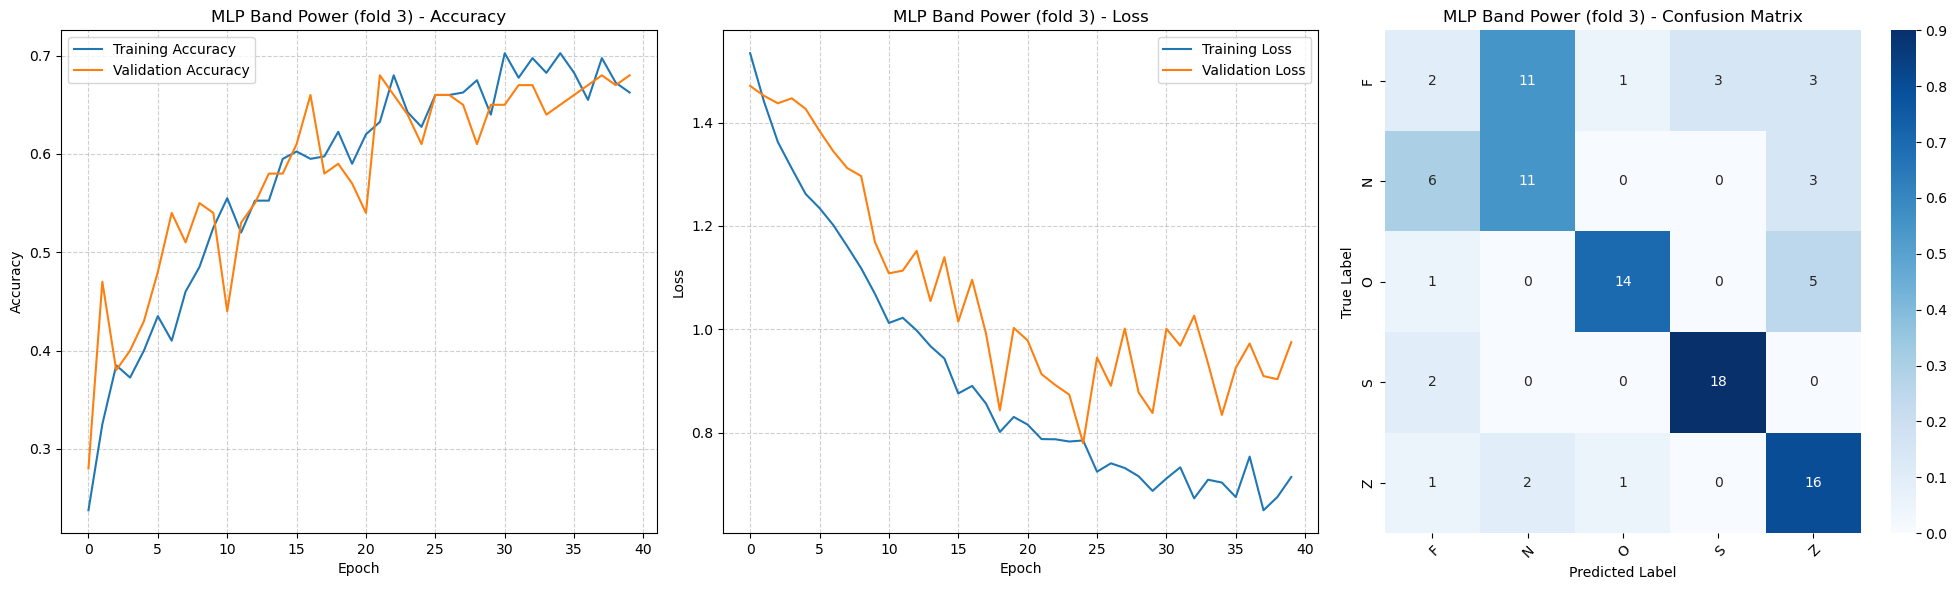

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,800 (26.56 KB)

 Trainable params: 6,789 (26.52 KB)

 Non-trainable params: 11 (44.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2402 - loss: 1.6035 - val_accuracy: 0.3600 - val_loss: 1.4649
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2928 - loss: 1.5030 - val_accuracy: 0.4500 - val_loss: 1.3891
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4224 - loss: 1.3880 - val_accuracy: 0.4200 - val_loss: 1.3350
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3514 - loss: 1.3730 - val_accuracy: 0.4200 - val_loss: 1.2915
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3943 - loss: 1.3303 - val_accuracy: 0.4800 - val_loss: 1.2496
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3843 - loss: 1.2921 - val_accuracy: 0.4900 - val_loss: 1.2126
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4513 - loss: 1.2282 - val_accuracy: 0.4500 - val_loss: 1.1894
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4352 - loss: 1.2624 - val_accuracy: 0.4900 - v

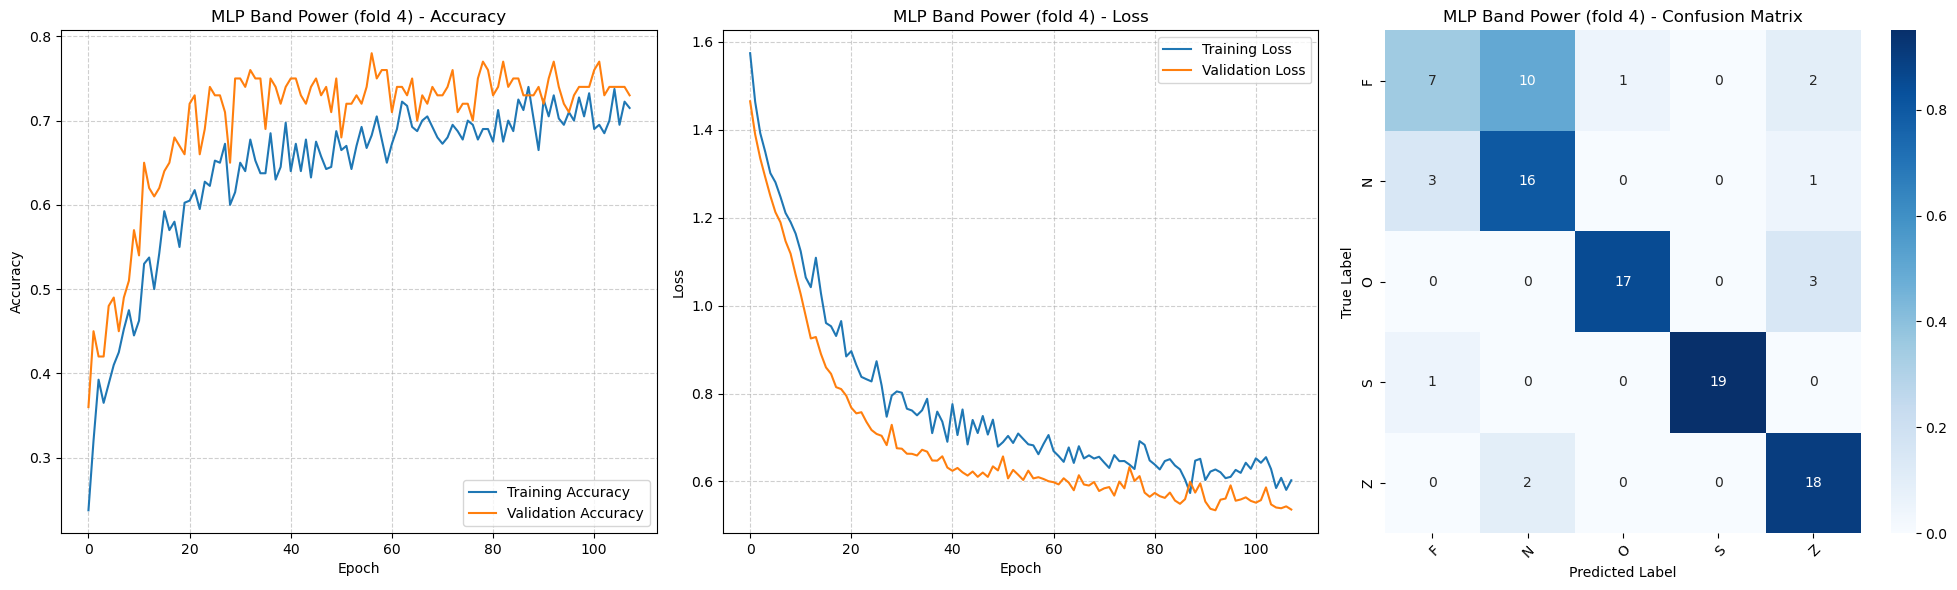

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,800 (26.56 KB)

 Trainable params: 6,789 (26.52 KB)

 Non-trainable params: 11 (44.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2425 - loss: 1.6067 - val_accuracy: 0.4300 - val_loss: 1.4651
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3296 - loss: 1.5104 - val_accuracy: 0.4400 - val_loss: 1.3604
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4027 - loss: 1.4153 - val_accuracy: 0.4000 - val_loss: 1.2759
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4038 - loss: 1.3792 - val_accuracy: 0.4200 - val_loss: 1.2176
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3756 - loss: 1.3127 - val_accuracy: 0.4600 - val_loss: 1.1765
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4415 - loss: 1.2715 - val_accuracy: 0.5300 - val_loss: 1.1316
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3182 - loss: 1.2857 - val_accuracy: 0.5800 - val_loss: 1.1019
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4342 - loss: 1.2266 - val_accuracy: 0.5900 - v

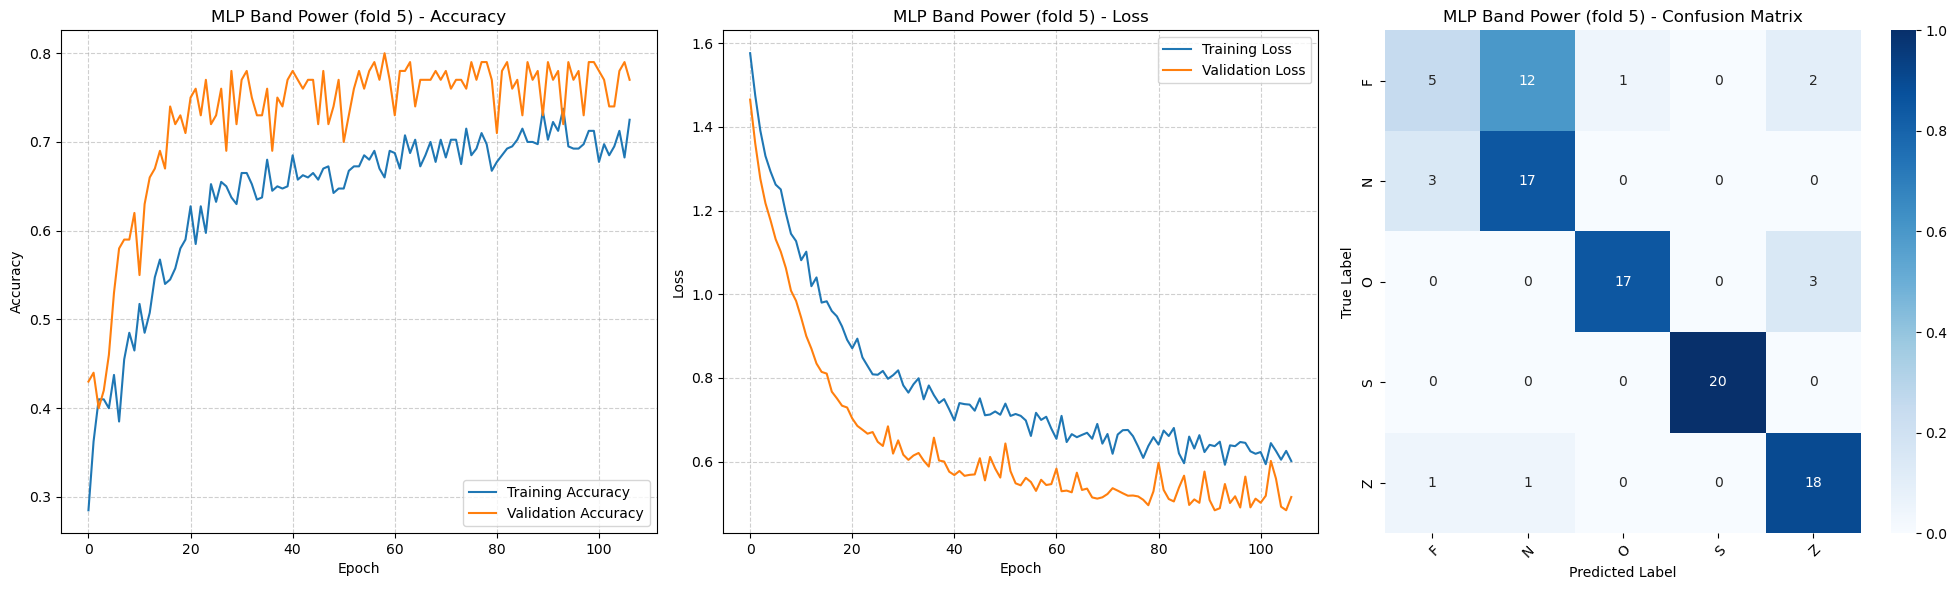

=== MLP Band Power | 5-fold CV ===
Fold 1: acc=0.7600 | f1=0.7113 | P=0.8310 | R=0.7600
Fold 2: acc=0.7600 | f1=0.7225 | P=0.7872 | R=0.7600
Fold 3: acc=0.6100 | f1=0.5923 | P=0.5899 | R=0.6100
Fold 4: acc=0.7700 | f1=0.7611 | P=0.7804 | R=0.7700
Fold 5: acc=0.7700 | f1=0.7514 | P=0.7699 | R=0.7700
Média±DP  acc: 0.7340 ± 0.0622
Média±DP   f1: 0.7077 ± 0.0605
Média±DP prec: 0.7517 ± 0.0835
Média±DP  rec: 0.7340 ± 0.0622
--- Coarse tasks (média ± DP) ---
Healthy vs Unhealthy:
  acc: 0.9440 ± 0.0185
  f1: 0.9297 ± 0.0241
  precision: 0.9300 ± 0.0188
  recall: 0.9300 ± 0.0367
N-I vs I-I vs I:
  acc: 0.9260 ± 0.0258
  f1: 0.9262 ± 0.0255
  precision: 0.9270 ± 0.0251
  recall: 0.9260 ± 0.0258
Seizure vs Non-Seizure:
  acc: 0.9820 ± 0.0172
  f1: 0.9554 ± 0.0418
  precision: 0.9614 ± 0.0556
  recall: 0.9500 ± 0.0316


In [52]:
X_band, y_band = dict_to_Xy(band_power_data)
results = do_kfold(
    create_model=create_mlp,
    X=X_band,
    y=y_band,
    n_splits=5,
    random_state=42,
    stratify=True,
    epochs=200,
    batch_size=8,
    verbose=2,
    feature_name="MLP Band Power",
    coarse_tasks=coarse_tasks
)

# # model, _ = train_and_evaluate(X_train_band, X_test_band, y_train_band, y_test_band, "Band power data")
# models["MLP Band Power"]["model"] = model

#### Experimenting with the band power based classifier

##### Calculating other important features

In [59]:
from scipy.stats import entropy

expanded_band_power_dict = {}

for key, band_powers_df in band_powers_df_dict.items():
    # Create a new DataFrame for each class
    expanded_features = band_powers_df.copy()
    
    # 1. Add relative band powers (normalize by total power)
    total_power = band_powers_df.sum(axis=1)
    for band in bands.keys():
        expanded_features[f'Rel_{band}'] = band_powers_df[band] / total_power
    
    # 2. Add band power ratios
    expanded_features['Theta_Alpha_Ratio'] = band_powers_df['Theta'] / band_powers_df['Alpha']
    expanded_features['Beta_Alpha_Ratio'] = band_powers_df['Beta'] / band_powers_df['Alpha']
    expanded_features['Gamma_Beta_Ratio'] = band_powers_df['Gamma'] / band_powers_df['Beta']
    expanded_features['HighLow_Ratio'] = (band_powers_df['Beta'] + band_powers_df['Gamma']) / (band_powers_df['Delta'] + band_powers_df['Theta'])
    
    # # 3. Calculate spectral entropy for each sample from the original frequency data
    # spectral_entropy = []
    # for i in range(len(psd_dict[key])):
    #     # Normalize PSD (probability distribution)
    #     psd = psd_dict[key][i]
    #     psd_norm = psd / np.sum(psd)
    #     # Calculate entropy
    #     spectral_entropy.append(entropy(psd_norm))
    
    # expanded_features['Spectral_Entropy'] = spectral_entropy
    
    # # 4. Calculate band entropy (entropy within each frequency band)
    # for band_name, (low_freq, high_freq) in bands.items():
    #     band_entropy = []
    #     for i in range(len(psd_dict[key])):
    #         band_idx = np.logical_and(frequencies >= low_freq, frequencies <= high_freq)
    #         band_psd = psd_dict[key][i][band_idx]
    #         # Skip if band has no frequency components
    #         if len(band_psd) > 1:
    #             band_psd_norm = band_psd / np.sum(band_psd)
    #             band_entropy.append(entropy(band_psd_norm))
    #         else:
    #             band_entropy.append(0)  # Default if not enough data points
        
    #     expanded_features[f'{band_name}_Entropy'] = band_entropy
    
    # Store in the new dictionary
    expanded_band_power_dict[key] = expanded_features

# Print summary of expanded features
sample_key = list(expanded_band_power_dict.keys())[0]
print(f"Original features: {list(band_powers_df_dict[sample_key].columns)}")
print(f"Expanded features: {list(expanded_band_power_dict[sample_key].columns)}")
print(f"Number of features: {len(expanded_band_power_dict[sample_key].columns)}")
print(f"Shape of expanded features for {sample_key}: {expanded_band_power_dict[sample_key].shape}")

Original features: ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
Expanded features: ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Rel_Delta', 'Rel_Theta', 'Rel_Alpha', 'Rel_Beta', 'Rel_Gamma', 'Theta_Alpha_Ratio', 'Beta_Alpha_Ratio', 'Gamma_Beta_Ratio', 'HighLow_Ratio']
Number of features: 14
Shape of expanded features for Z: (100, 14)


##### Setting up a model with the new expanded features

In [ ]:
# # splitting expanded band power data into train and test sets
# X_train_expanded, X_test_expanded, y_train_expanded, y_test_expanded = split_data(expanded_band_power_dict)
# # printing shapes for verification
# print("Expanded Band Power data:", X_train_expanded.shape, X_test_expanded.shape)

# models["MLP Expanded Features"]["X_test"] = X_test_expanded
# models["MLP Expanded Features"]["y_test"] = y_test_expanded


Expanded Band Power data: (400, 20) (100, 20)


In [60]:
X_expa, y_expa = dict_to_Xy(expanded_band_power_dict)
results = do_kfold(
    create_model=create_mlp,
    X=X_expa,
    y=y_expa,
    n_splits=5,
    random_state=42,
    stratify=True,
    epochs=200,
    batch_size=8,
    verbose=0,
    feature_name="MLP Expanded Features",
    coarse_tasks=coarse_tasks
)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2318 - loss: 1.6671 - val_accuracy: 0.5900 - val_loss: 1.2917
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4332 - loss: 1.3932 - val_accuracy: 0.6300 - val_loss: 1.0260
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5782 - loss: 1.1345 - val_accuracy: 0.6200 - val_loss: 0.8091
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6084 - loss: 0.9735 - val_accuracy: 0.6800 - val_loss: 0.6766
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5970 - loss: 0.8950 - val_accuracy: 0.7200 - val_loss: 0.5973
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6201 - loss: 0.8227 - val_accuracy: 0.7500 - val_loss: 0.5408
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7606 - loss: 0.7204 - val_accuracy: 0.7000 - val_loss: 0.5261
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6479 - loss: 0.8414 - val_accuracy: 0.7400 - v

#### Setting up CNN's to classify time and frequency data

In [65]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Function to create a CNN model for 1D time series data
def create_cnn_time(input_dim, num_classes, verbose=0):
    model = Sequential([
        Input(shape=(input_dim, 1)),                 # (T, C=1)
        Normalization(axis=-1),                     # normaliza por canal
        Conv1D(16, kernel_size=32, strides=4, activation='relu', padding='same'),
        Dropout(0.5),
        MaxPooling1D(pool_size=8),
        Conv1D(16, kernel_size=4, activation='relu', padding='same'),
        Dropout(0.5),
        MaxPooling1D(pool_size=4),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    if verbose:
        model.summary()
    model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to create a CNN model for frequency domain data (shorter sequences)
def create_cnn_freq(input_dim, num_classes, verbose=0):
    model = Sequential([
        Input(shape=(input_dim, 1)),                # (F, C=1)
        Normalization(axis=-1),
        Conv1D(16, kernel_size=4, activation='relu', padding='same'),
        Dropout(0.5),
        MaxPooling1D(pool_size=2),
        Conv1D(16, kernel_size=2, activation='relu', padding='same'),
        Dropout(0.3),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    if verbose:
        model.summary()
    model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049, 1)        │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 513, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 513, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,768 (22.53 KB)

 Trainable params: 5,765 (22.52 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2076 - loss: 1.7848 - val_accuracy: 0.3500 - val_loss: 1.4259
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2875 - loss: 1.3917 - val_accuracy: 0.4100 - val_loss: 1.3716
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3813 - loss: 1.3233 - val_accuracy: 0.5900 - val_loss: 1.3130
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5027 - loss: 1.2486 - val_accuracy: 0.6000 - val_loss: 1.1990
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5988 - loss: 1.0390 - val_accuracy: 0.6800 - val_loss: 1.0493
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6675 - loss: 0.9122 - val_accuracy: 0.7000 - val_loss: 0.9902
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7241 - loss: 0.7562 - val_accuracy: 0.8100 - val_loss: 0.9152
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6759 - loss: 0.7508 - val_accuracy: 0.7600 - v

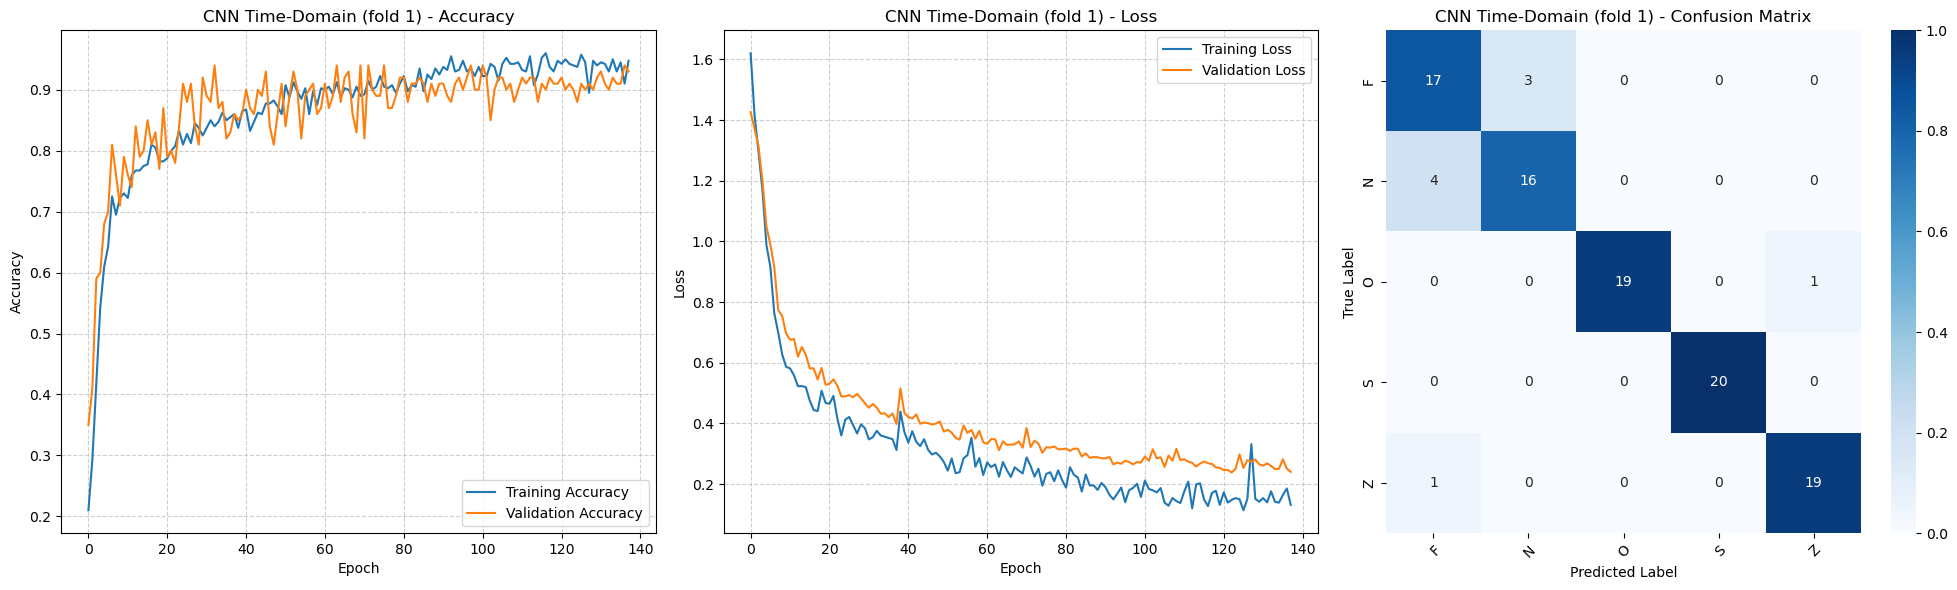

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049, 1)        │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 513, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 513, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,768 (22.53 KB)

 Trainable params: 5,765 (22.52 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2481 - loss: 1.4790 - val_accuracy: 0.2800 - val_loss: 1.4974
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2629 - loss: 1.3925 - val_accuracy: 0.3700 - val_loss: 1.4090
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4074 - loss: 1.2178 - val_accuracy: 0.4700 - val_loss: 1.2847
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4561 - loss: 1.1467 - val_accuracy: 0.4700 - val_loss: 1.1932
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5701 - loss: 1.0024 - val_accuracy: 0.6500 - val_loss: 1.1008
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5785 - loss: 0.8817 - val_accuracy: 0.7800 - val_loss: 0.9601
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6467 - loss: 0.8035 - val_accuracy: 0.7400 - val_loss: 0.8770
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7286 - loss: 0.6255 - val_accuracy: 0.7700 - v

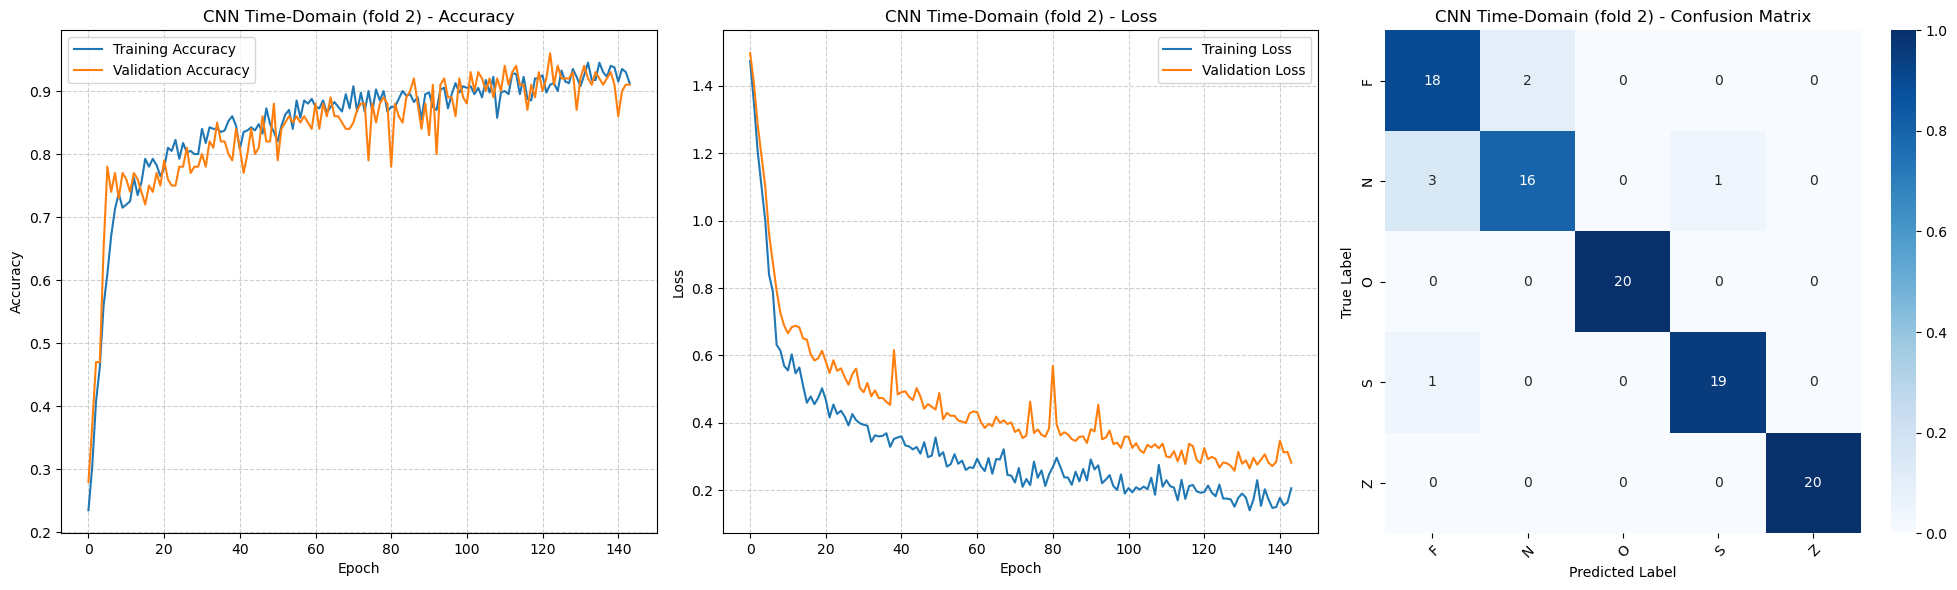

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049, 1)        │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 513, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 513, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,768 (22.53 KB)

 Trainable params: 5,765 (22.52 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1761 - loss: 1.7756 - val_accuracy: 0.3300 - val_loss: 1.4776
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3113 - loss: 1.4303 - val_accuracy: 0.4100 - val_loss: 1.4256
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3915 - loss: 1.3424 - val_accuracy: 0.4900 - val_loss: 1.3619
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4883 - loss: 1.2422 - val_accuracy: 0.5700 - val_loss: 1.2553
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4709 - loss: 1.1325 - val_accuracy: 0.5700 - val_loss: 1.1536
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5885 - loss: 0.9924 - val_accuracy: 0.7100 - val_loss: 1.0303
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6532 - loss: 0.8873 - val_accuracy: 0.7300 - val_loss: 0.9286
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7135 - loss: 0.7012 - val_accuracy: 0.7000 - v

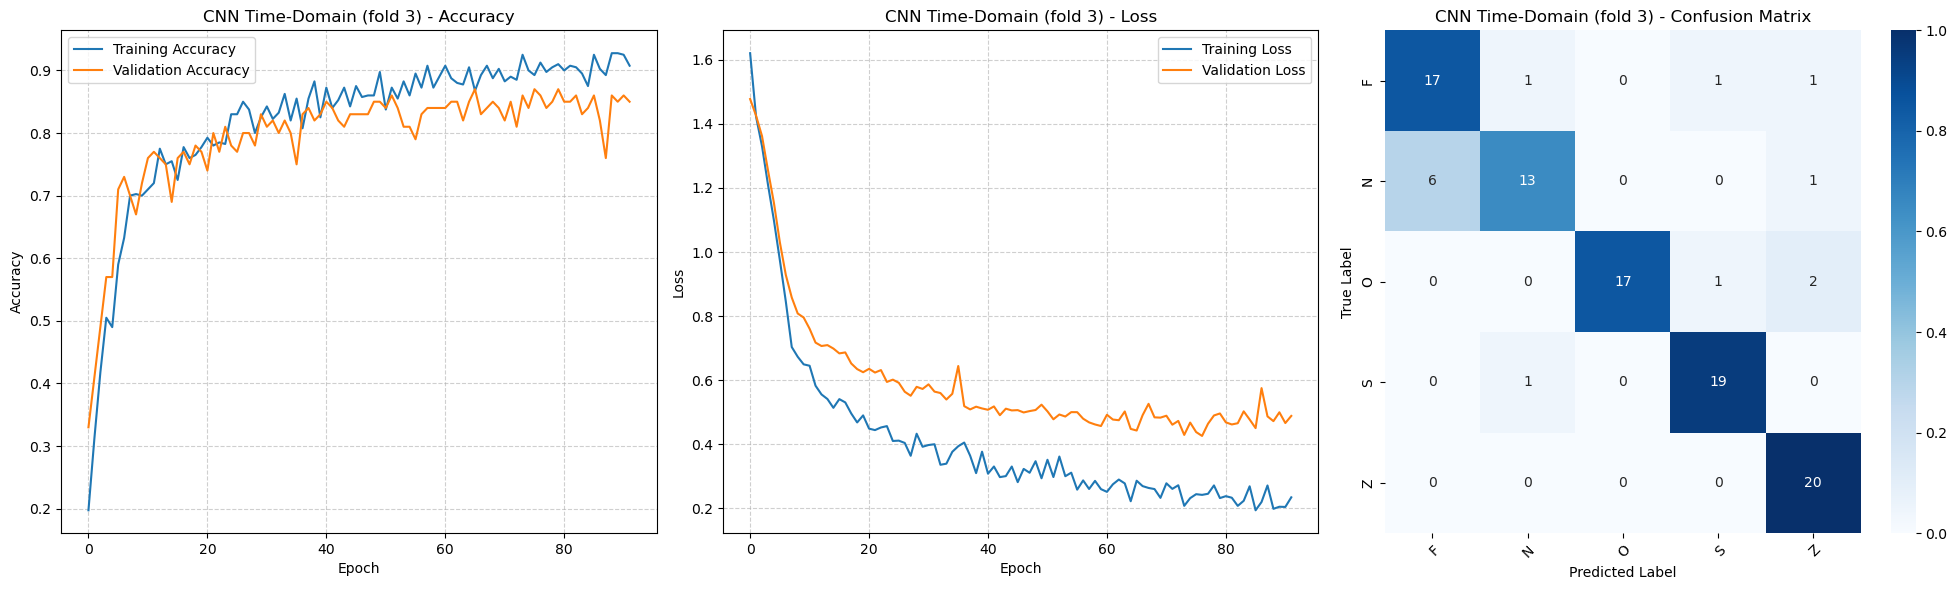

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049, 1)        │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 513, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 513, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,768 (22.53 KB)

 Trainable params: 5,765 (22.52 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2049 - loss: 1.7850 - val_accuracy: 0.3300 - val_loss: 1.4998
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2969 - loss: 1.4353 - val_accuracy: 0.3500 - val_loss: 1.4420
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3548 - loss: 1.3384 - val_accuracy: 0.3500 - val_loss: 1.3902
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3742 - loss: 1.3510 - val_accuracy: 0.4100 - val_loss: 1.3108
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4015 - loss: 1.2352 - val_accuracy: 0.5500 - val_loss: 1.1943
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5404 - loss: 1.0710 - val_accuracy: 0.6000 - val_loss: 1.1223
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5987 - loss: 0.9929 - val_accuracy: 0.6600 - val_loss: 0.9514
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6837 - loss: 0.7361 - val_accuracy: 0.7200 - v

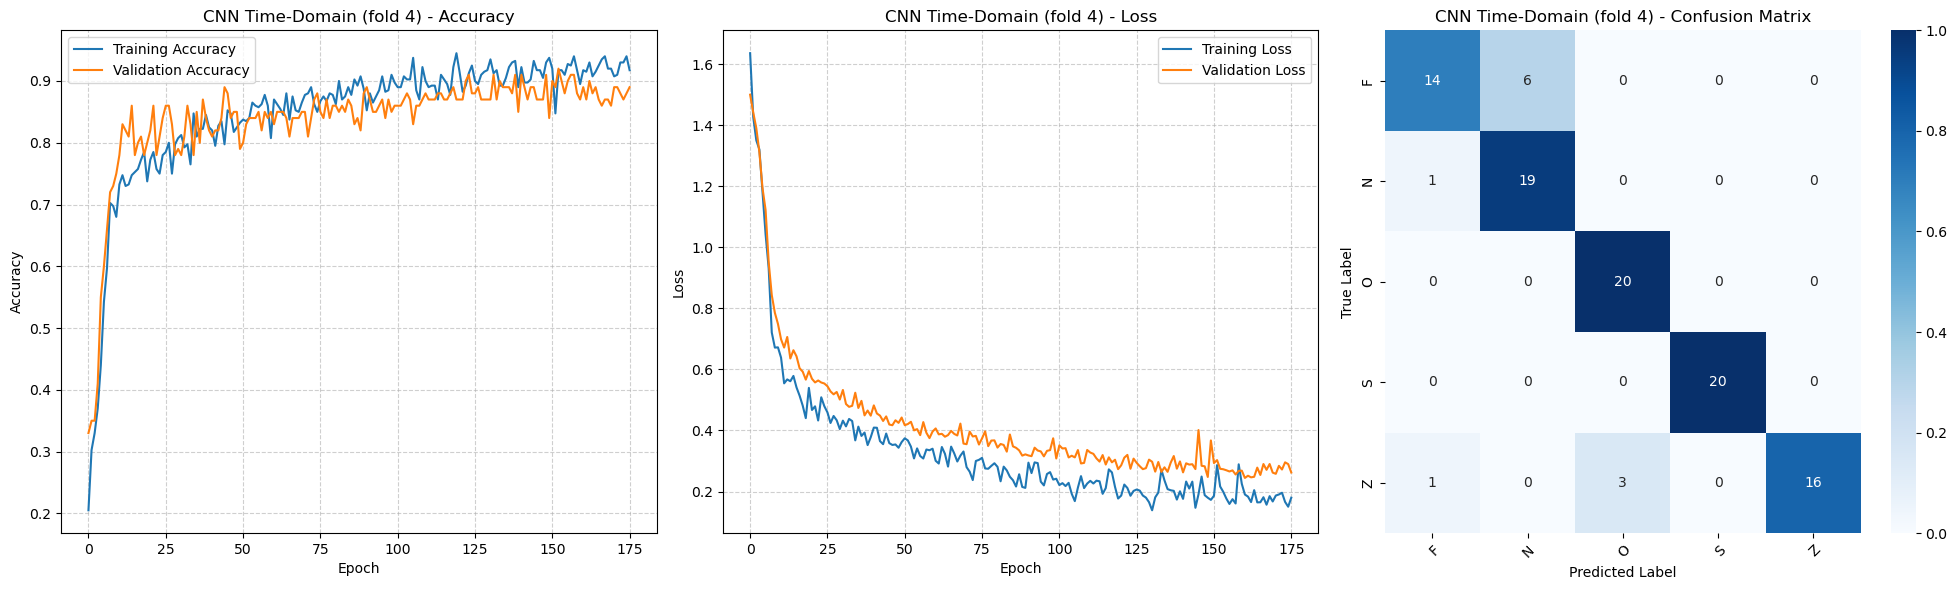

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2049, 1)        │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 513, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 513, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,768 (22.53 KB)

 Trainable params: 5,765 (22.52 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2143 - loss: 1.9111 - val_accuracy: 0.2600 - val_loss: 1.4174
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2973 - loss: 1.4239 - val_accuracy: 0.4200 - val_loss: 1.3721
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3903 - loss: 1.3546 - val_accuracy: 0.6500 - val_loss: 1.2743
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4490 - loss: 1.1926 - val_accuracy: 0.5500 - val_loss: 1.1316
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6050 - loss: 1.0016 - val_accuracy: 0.6700 - val_loss: 0.9931
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5663 - loss: 0.9337 - val_accuracy: 0.7400 - val_loss: 0.9052
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6393 - loss: 0.7871 - val_accuracy: 0.7400 - val_loss: 0.8112
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6545 - loss: 0.6837 - val_accuracy: 0.7800 - v

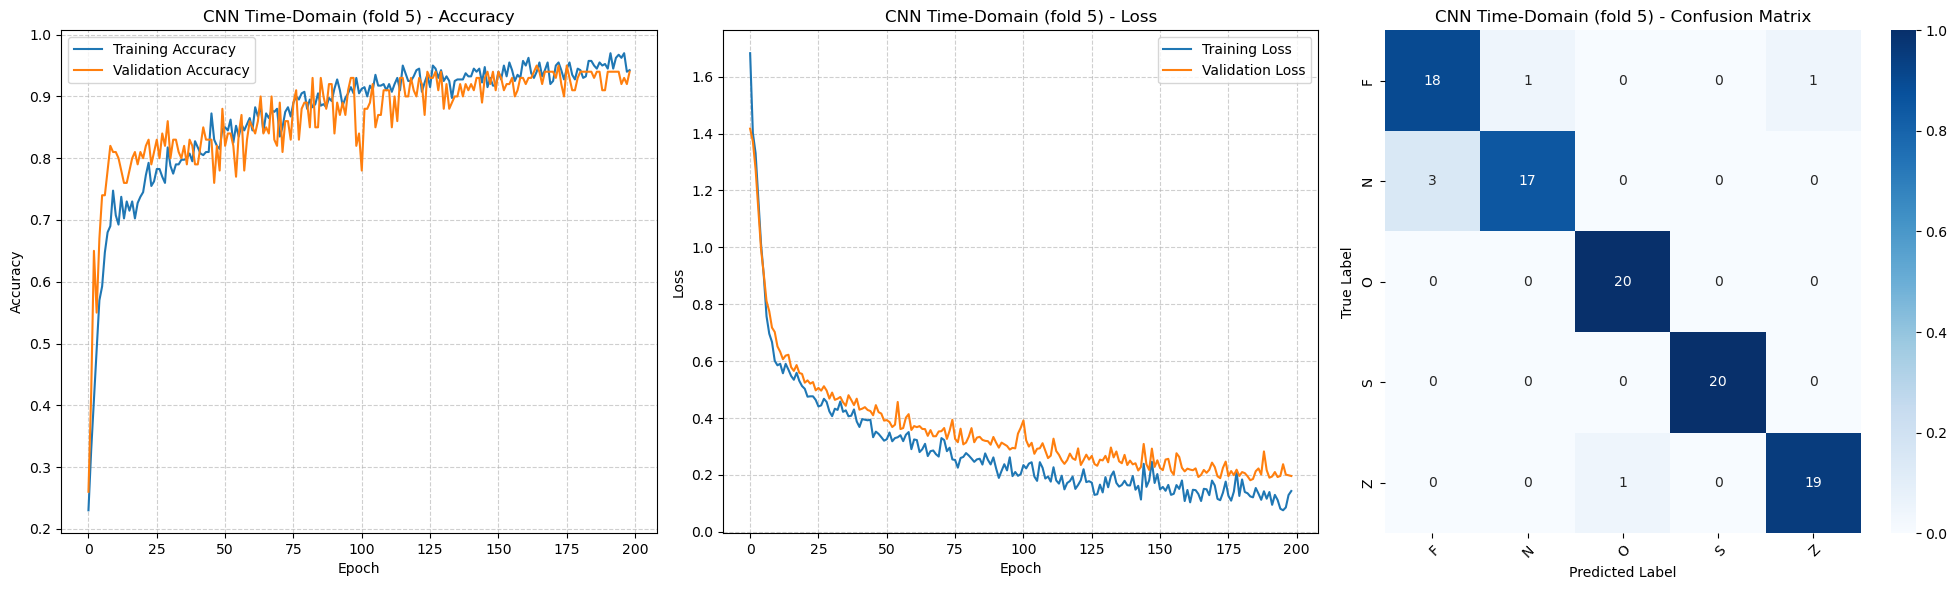

=== CNN Time-Domain | 5-fold CV ===
Fold 1: acc=0.9100 | f1=0.9109 | P=0.9130 | R=0.9100
Fold 2: acc=0.9300 | f1=0.9298 | P=0.9314 | R=0.9300
Fold 3: acc=0.8600 | f1=0.8577 | P=0.8688 | R=0.8600
Fold 4: acc=0.8900 | f1=0.8883 | P=0.9009 | R=0.8900
Fold 5: acc=0.9400 | f1=0.9397 | P=0.9408 | R=0.9400
Média±DP  acc: 0.9060 ± 0.0287
Média±DP   f1: 0.9053 ± 0.0296
Média±DP prec: 0.9110 ± 0.0253
Média±DP  rec: 0.9060 ± 0.0287
--- Coarse tasks (média ± DP) ---
Healthy vs Unhealthy:
  acc: 0.9900 ± 0.0063
  f1: 0.9875 ± 0.0079
  precision: 0.9901 ± 0.0121
  recall: 0.9850 ± 0.0122
N-I vs I-I vs I:
  acc: 0.9820 ± 0.0117
  f1: 0.9820 ± 0.0116
  precision: 0.9823 ± 0.0115
  recall: 0.9820 ± 0.0117
Seizure vs Non-Seizure:
  acc: 0.9920 ± 0.0098
  f1: 0.9800 ± 0.0245
  precision: 0.9800 ± 0.0245
  recall: 0.9800 ± 0.0245


In [66]:
X_time, y_time = dict_to_Xy(time_data)
results = do_kfold(
    create_model=create_cnn_time,
    X=X_time,
    y=y_time,
    n_splits=5,
    random_state=42,
    stratify=True,
    epochs=200,
    batch_size=8,
    verbose=2,
    feature_name="CNN Time-Domain",
    coarse_tasks=coarse_tasks
)

##### Training CNN-Freq

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 129, 1)         │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 129, 16)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 129, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,904 (34.78 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2767 - loss: 1.7294 - val_accuracy: 0.4100 - val_loss: 1.3675
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3619 - loss: 1.3640 - val_accuracy: 0.6400 - val_loss: 1.2871
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4532 - loss: 1.2755 - val_accuracy: 0.5400 - val_loss: 1.2186
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4461 - loss: 1.2222 - val_accuracy: 0.6400 - val_loss: 1.1601
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5674 - loss: 1.1490 - val_accuracy: 0.6900 - val_loss: 1.1073
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5246 - loss: 1.0419 - val_accuracy: 0.6900 - val_loss: 1.0374
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5622 - loss: 0.9644 - val_accuracy: 0.6900 - val_loss: 1.0117
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6337 - loss: 0.8853 - val_accuracy: 0.5600 - 

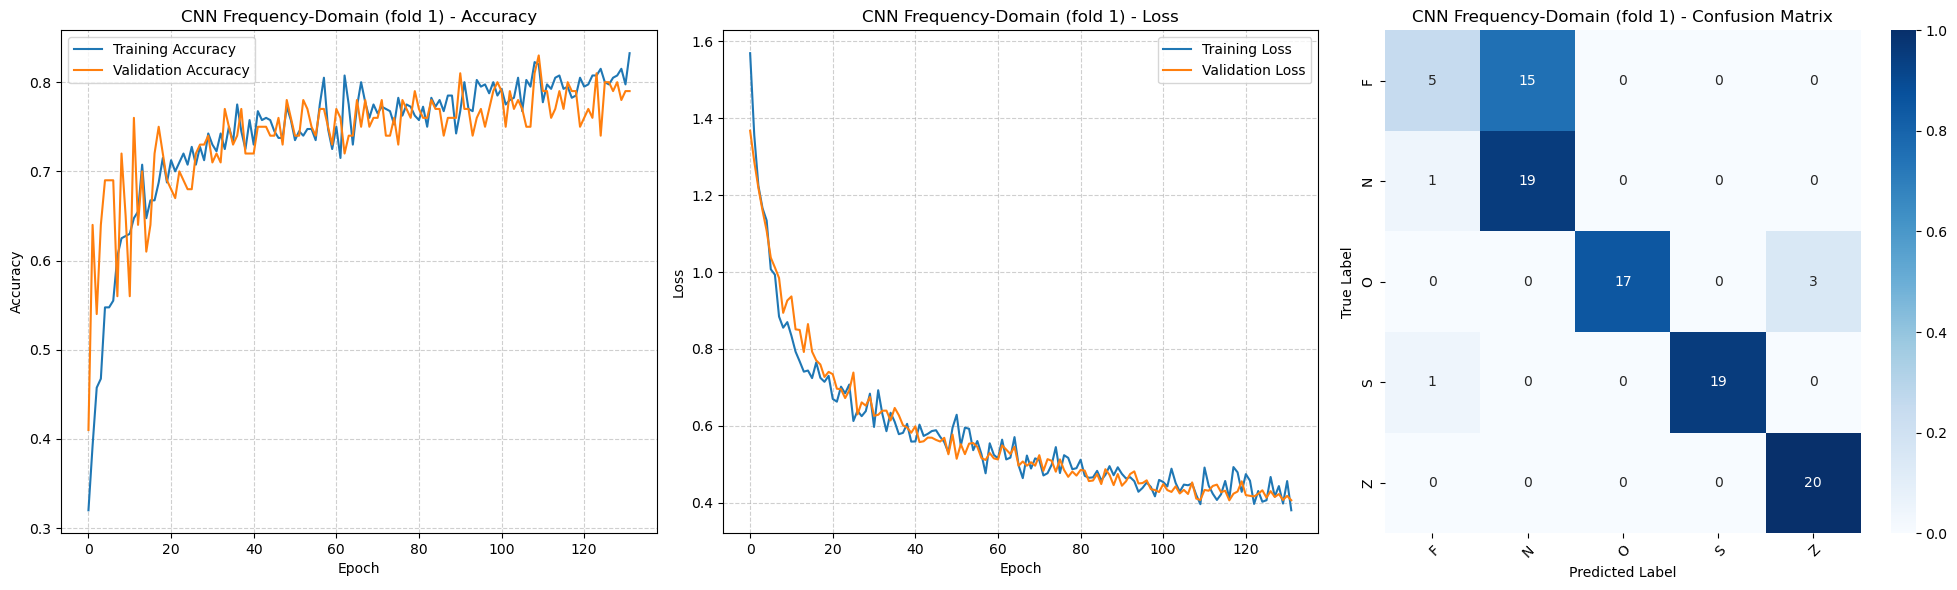

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 129, 1)         │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 129, 16)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 129, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,904 (34.78 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2102 - loss: 1.6764 - val_accuracy: 0.3500 - val_loss: 1.5087
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3554 - loss: 1.3800 - val_accuracy: 0.3800 - val_loss: 1.4227
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3538 - loss: 1.3189 - val_accuracy: 0.4000 - val_loss: 1.3233
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4102 - loss: 1.2328 - val_accuracy: 0.6700 - val_loss: 1.2645
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5381 - loss: 1.1228 - val_accuracy: 0.5500 - val_loss: 1.2095
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5500 - loss: 1.0831 - val_accuracy: 0.5800 - val_loss: 1.1107
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5682 - loss: 1.0199 - val_accuracy: 0.6900 - val_loss: 1.0225
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5866 - loss: 0.9258 - val_accuracy: 0.6200 - v

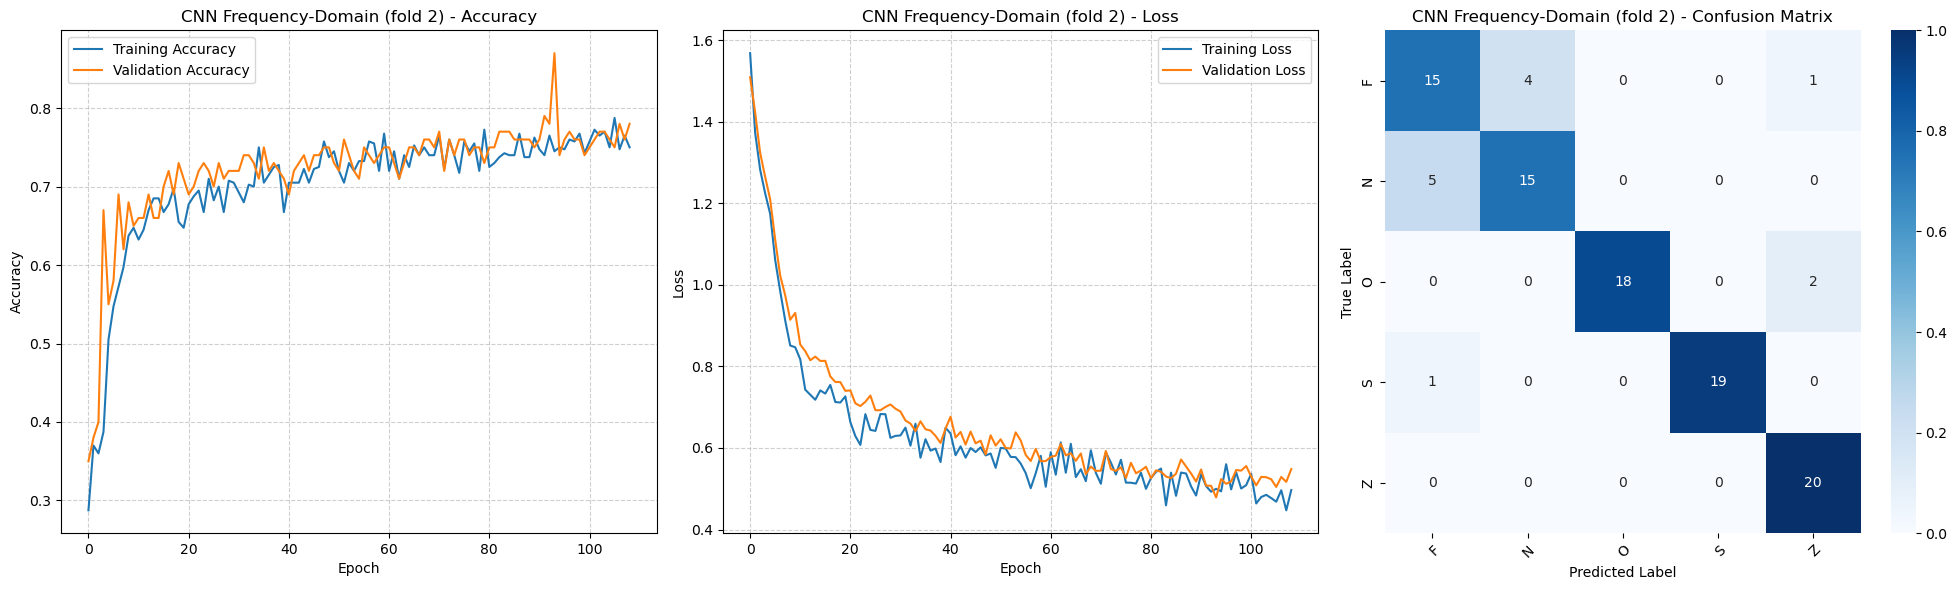

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 129, 1)         │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 129, 16)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 129, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,904 (34.78 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1996 - loss: 1.6512 - val_accuracy: 0.3500 - val_loss: 1.5298
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3577 - loss: 1.4256 - val_accuracy: 0.4100 - val_loss: 1.3749
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4116 - loss: 1.3021 - val_accuracy: 0.5300 - val_loss: 1.3383
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4796 - loss: 1.1827 - val_accuracy: 0.5300 - val_loss: 1.2895
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5264 - loss: 1.1306 - val_accuracy: 0.6000 - val_loss: 1.2248
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4819 - loss: 1.1243 - val_accuracy: 0.6200 - val_loss: 1.1608
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5365 - loss: 1.0147 - val_accuracy: 0.6100 - val_loss: 1.1315
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5899 - loss: 0.9533 - val_accuracy: 0.6500 - v

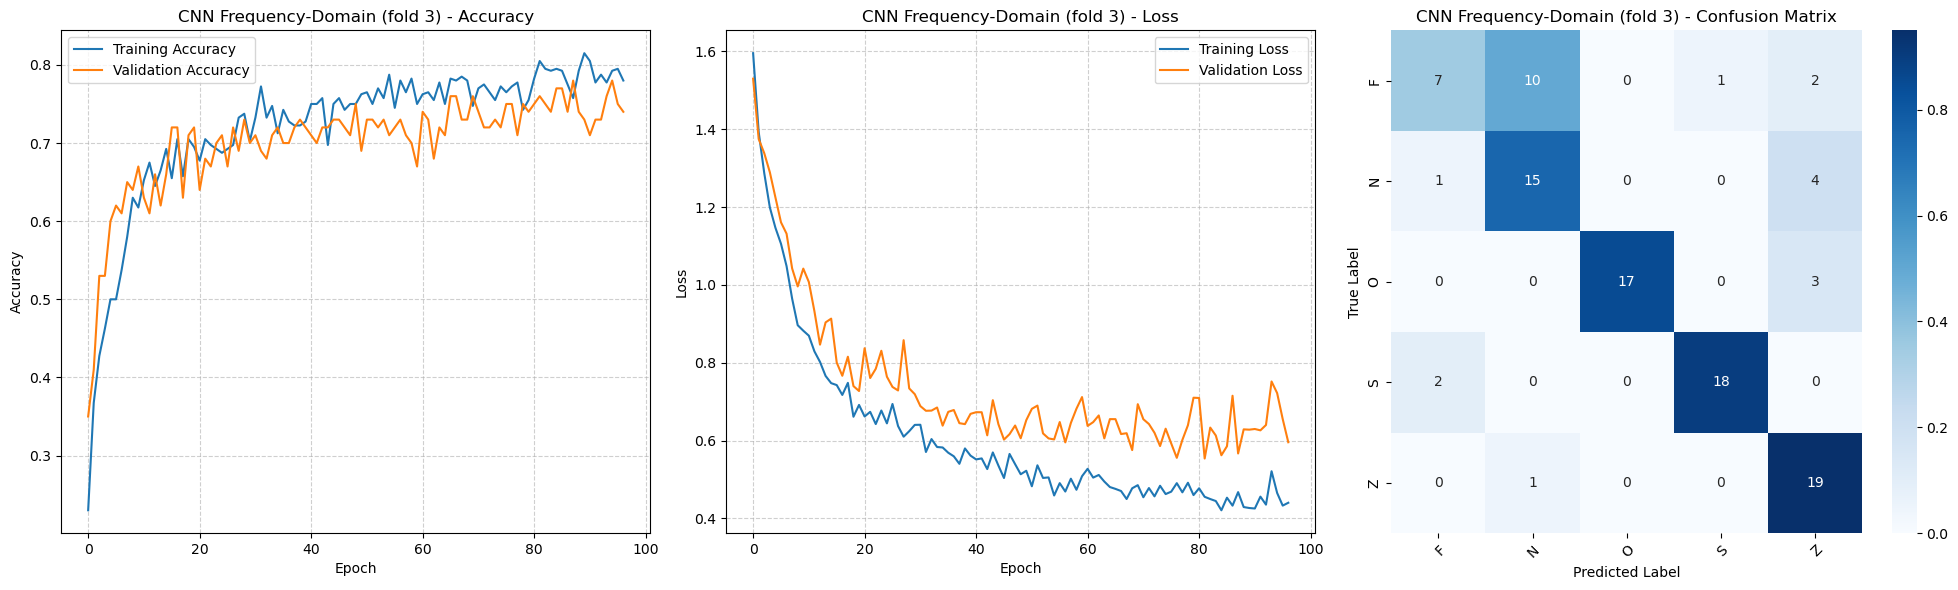

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 129, 1)         │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 129, 16)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 129, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,904 (34.78 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2001 - loss: 1.6150 - val_accuracy: 0.3500 - val_loss: 1.4894
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3496 - loss: 1.4218 - val_accuracy: 0.4700 - val_loss: 1.4003
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3651 - loss: 1.3880 - val_accuracy: 0.5000 - val_loss: 1.3414
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4496 - loss: 1.3087 - val_accuracy: 0.4900 - val_loss: 1.2353
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4110 - loss: 1.2330 - val_accuracy: 0.5200 - val_loss: 1.1451
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5389 - loss: 1.1075 - val_accuracy: 0.5100 - val_loss: 1.0470
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5520 - loss: 1.0036 - val_accuracy: 0.6900 - val_loss: 0.9811
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5425 - loss: 0.9884 - val_accuracy: 0.7200 - v

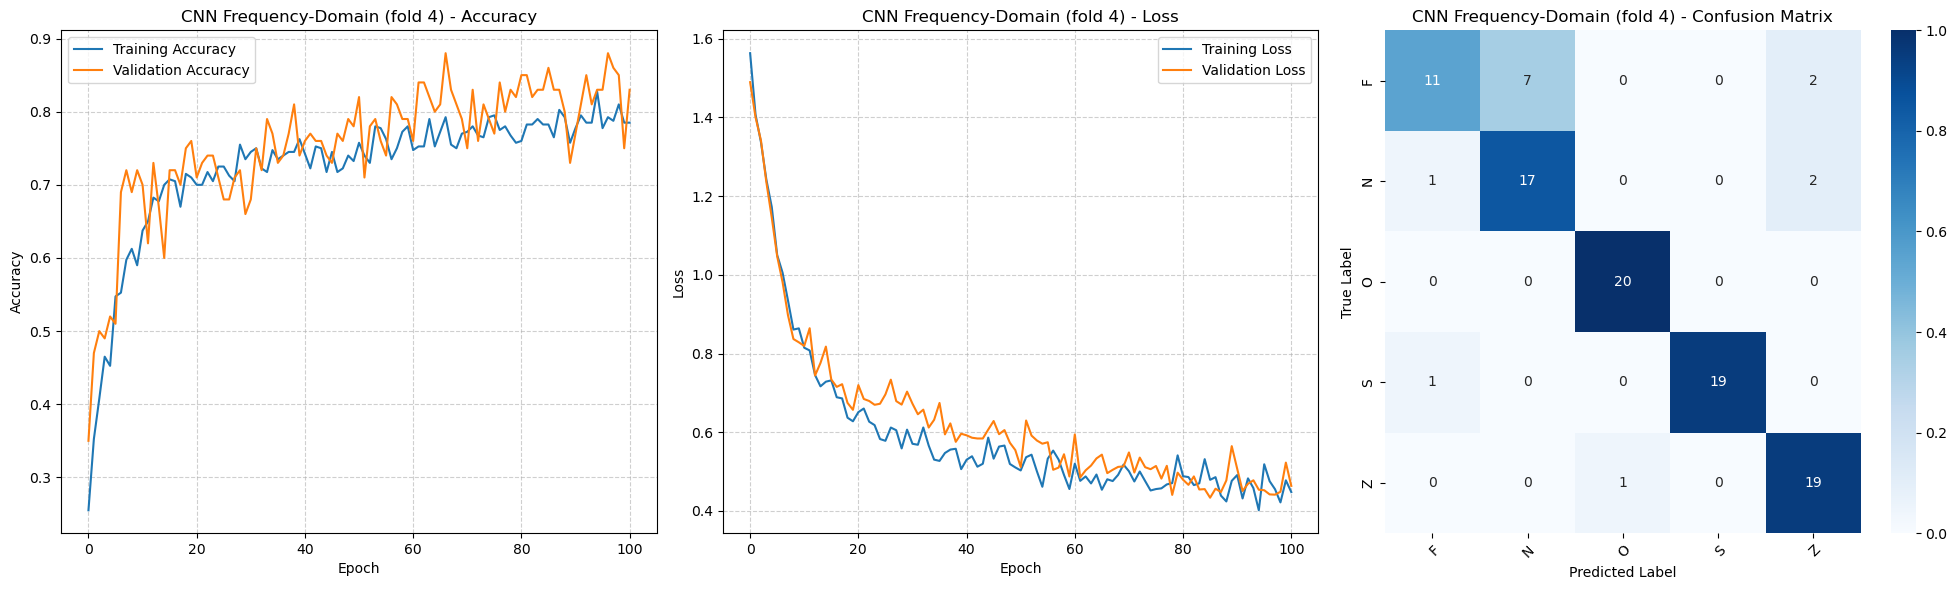

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 129, 1)         │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 129, 16)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 129, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,904 (34.78 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 3 (12.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2935 - loss: 1.5094 - val_accuracy: 0.3800 - val_loss: 1.3587
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3975 - loss: 1.2861 - val_accuracy: 0.3900 - val_loss: 1.2538
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3863 - loss: 1.3260 - val_accuracy: 0.4900 - val_loss: 1.1977
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4635 - loss: 1.1991 - val_accuracy: 0.5500 - val_loss: 1.1453
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4759 - loss: 1.1523 - val_accuracy: 0.6800 - val_loss: 1.0741
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5764 - loss: 1.0618 - val_accuracy: 0.5400 - val_loss: 1.0243
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5503 - loss: 0.9744 - val_accuracy: 0.6800 - val_loss: 0.9406
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5404 - loss: 1.0127 - val_accuracy: 0.6900 - v

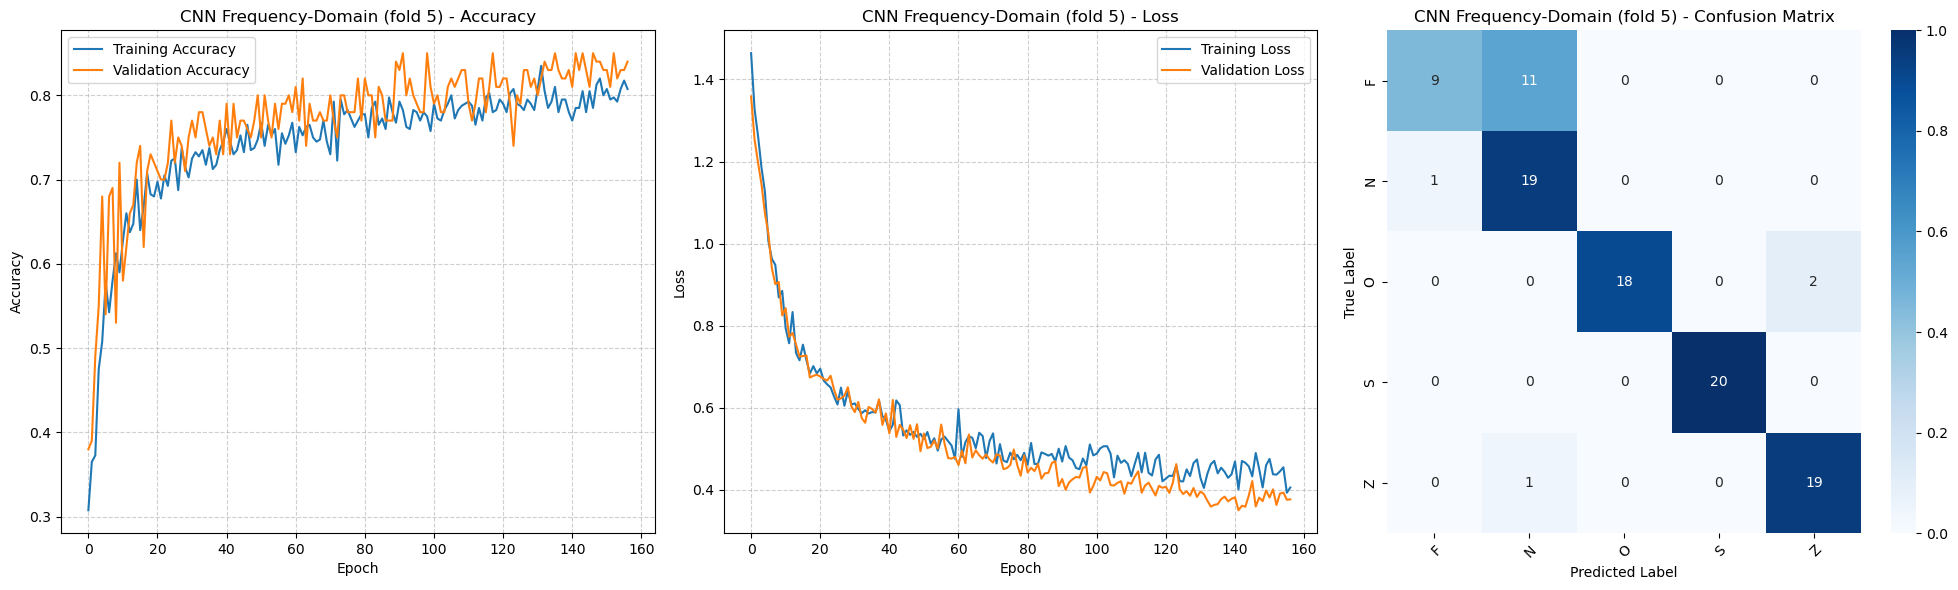

=== CNN Frequency-Domain | 5-fold CV ===
Fold 1: acc=0.8000 | f1=0.7795 | P=0.8285 | R=0.8000
Fold 2: acc=0.8700 | f1=0.8706 | P=0.8747 | R=0.8700
Fold 3: acc=0.7600 | f1=0.7505 | P=0.7806 | R=0.7600
Fold 4: acc=0.8600 | f1=0.8546 | P=0.8666 | R=0.8600
Fold 5: acc=0.8500 | f1=0.8439 | P=0.8835 | R=0.8500
Média±DP  acc: 0.8280 ± 0.0417
Média±DP   f1: 0.8198 ± 0.0465
Média±DP prec: 0.8468 ± 0.0380
Média±DP  rec: 0.8280 ± 0.0417
--- Coarse tasks (média ± DP) ---
Healthy vs Unhealthy:
  acc: 0.9820 ± 0.0075
  f1: 0.9773 ± 0.0094
  precision: 0.9849 ± 0.0124
  recall: 0.9700 ± 0.0100
N-I vs I-I vs I:
  acc: 0.9700 ± 0.0141
  f1: 0.9700 ± 0.0141
  precision: 0.9706 ± 0.0141
  recall: 0.9700 ± 0.0141
Seizure vs Non-Seizure:
  acc: 0.9880 ± 0.0098
  f1: 0.9692 ± 0.0251
  precision: 0.9895 ± 0.0211
  recall: 0.9500 ± 0.0316


In [67]:
X_freq, y_freq = dict_to_Xy(frequency_data)
results = do_kfold(
    create_model=create_cnn_freq,
    X=X_freq,
    y=y_freq,
    n_splits=5,
    random_state=42,
    stratify=True,
    epochs=200,
    batch_size=8,
    verbose=2,
    feature_name="CNN Frequency-Domain",
    coarse_tasks=coarse_tasks
)

##### Displaying the network summaries

In [ ]:
# Print model summaries
print("CNN Model for Time-Domain Data:")
time_model = create_cnn_time((X_train_time.shape[1], 1), 5)
time_model.summary()

print("\nCNN Model for Frequency-Domain Data:")
freq_model = create_cnn_freq((X_train_freq.shape[1], 1), 5)
freq_model.summary()

CNN Model for Time-Domain Data:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_15                │ (None, 4097, 1)        │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1017, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1017, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 127, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 16)        │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 124, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 31, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 496)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 16)             │         7,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,608 (37.53 KB)

 Trainable params: 9,605 (37.52 KB)

 Non-trainable params: 3 (12.00 B)


CNN Model for Frequency-Domain Data:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_16                │ (None, 129, 1)         │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 126, 16)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 126, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 63, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 62, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 62, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 31, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 496)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 16)             │         7,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,648 (33.78 KB)

 Trainable params: 8,645 (33.77 KB)

 Non-trainable params: 3 (12.00 B)

##### Training the CNN's


=== Training CNN on Time-Domain Data ===
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2728 - loss: 1.5132 - val_accuracy: 0.1875 - val_loss: 1.5138
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2936 - loss: 1.4762 - val_accuracy: 0.3625 - val_loss: 1.4709
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3368 - loss: 1.3200 - val_accuracy: 0.5375 - val_loss: 1.4418
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4268 - loss: 1.3192 - val_accuracy: 0.6125 - val_loss: 1.3575
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5742 - loss: 1.2376 - val_accuracy: 0.6250 - val_loss: 1.2659
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5873 - loss: 1.0722 - val_accuracy: 0.6125 - val_loss: 1.1318
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6348 - loss: 0.9063 - val_accuracy: 0.6875 - val_loss: 1.0353
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6398

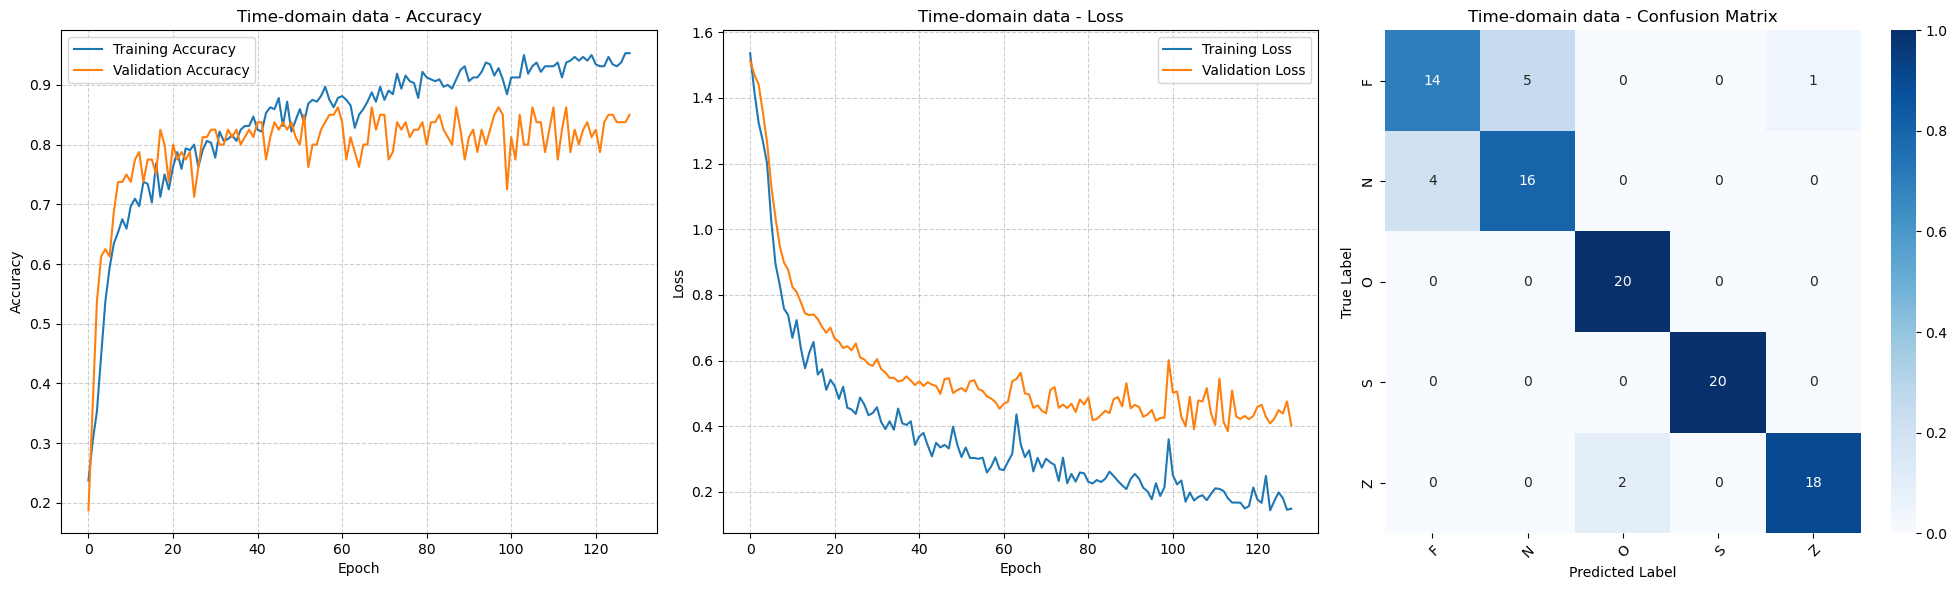

In [ ]:
# Train and evaluate CNN for time-domain data
print("\n=== Training CNN on Time-Domain Data ===")
time_cnn_model = train_and_evaluate_cnn(X_train_time, X_test_time, y_train_time, y_test_time, 
                                        "Time-domain data", is_time_domain=True)
models["CNN Time-Domain"]["model"] = time_cnn_model

### Testing the models out

#### defining the main classification tasks

In [ ]:
# Define the classification tasks
classification_tasks = {
    "All Classes": {
        "description": "All 5 EEG classes",
        "mapping": {
            "Z": "Z", "O": "O", "N": "N", "F": "F", "S": "S"
        }
    },
    "Healthy vs Unhealthy": {
        "description": "Healthy (Z, O) vs Unhealthy (N, F, S)",
        "mapping": {
            "Z": "Healthy", "O": "Healthy", "N": "Unhealthy", "F": "Unhealthy", "S": "Unhealthy"
        }
    },
    "Seizure vs Non-Seizure": {
        "description": "Seizure (S) vs Non-Seizure (Z, O, N, F)",
        "mapping": {
            "Z": "Non-Seizure", "O": "Non-Seizure", "N": "Non-Seizure", "F": "Non-Seizure", "S": "Seizure"
        }
    },
    "N-I vs I-I vs I": {
        "description": "Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ictal (S)",
        "mapping": {
            "Z": "Non-Ictal", "O": "Non-Ictal", "N": "Inter-Ictal", "F": "Inter-Ictal", "S": "Ictal"
        }
    }
}

#### doing the main comparisons between models

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# remap the classes according to the task
def remap_classes(y_orig, mapping):
    y_remapped = []
    # mask = []
    
    for i, cls in enumerate(y_orig):
        mapped_value = mapping.get(cls)
        # if mapped_value is not None:
        y_remapped.append(mapped_value)
            # mask.append(True)
        # else:
            # mask.append(False)

    return np.array(y_remapped) #, np.array(mask)

# Simplified and corrected evaluation function
def evaluate_model_on_task(model_info, task_info):
    model = model_info["model"]
    X_test = model_info["X_test"]
    y_true = model_info["y_test"]
    mapping = task_info["mapping"]

    # Step 1: Encode true labels
    # Encode true labels
    encoder = LabelEncoder()
    y_true_encoded = encoder.fit_transform(y_true)
    # One-hot encode the true labels
    y_true_categorical = to_categorical(y_true_encoded)

    # print(y_true)
    # print(y_true_encoded)
    # print(y_true_categorical)

    # print("---")

    # Step 2: Get label predictions from the model
    y_pred_proba = model.predict(X_test)
    y_pred_original_indices = np.argmax(y_pred_proba, axis=1)
    # print(y_pred_original_indices)

    # Step 2.5: Convert indices to original class labels
    y_pred_original = encoder.inverse_transform(y_pred_original_indices)
    # print(y_pred_original)

    # Step 3: Convert every class label to its corresponding task label
    y_true_remapped = remap_classes(y_true, mapping)
    y_pred_remapped = remap_classes(y_pred_original, mapping)


    # if len(y_remapped) == 0:
    #     return {"accuracy": np.nan, "f1": np.nan, "precision": np.nan, "recall": np.nan, "classes": []}
    
    # i dont know
    y_true_final = y_true_remapped
    y_pred_final = y_pred_remapped

    # Step 7: Calculate metrics
    accuracy = accuracy_score(y_true_final, y_pred_final)
    f1 = f1_score(y_true_final, y_pred_final, average='weighted')
    precision = precision_score(y_true_final, y_pred_final, average='weighted')
    recall = recall_score(y_true_final, y_pred_final, average='weighted')
    
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        # "classes": task_encoder.classes_
    }

# Create results list
results = []
confusion_matrices = {}

# Evaluate each model on each task
for model_name, model_info in models.items():
    if model_info["model"] is None:
        print(f"Model {model_name} not trained.")
        continue
        
    for task_name, task_info in classification_tasks.items():
        # if task_name != "Healthy vs Unhealthy" or model_name not in ["MLP Time-Domain", "CNN Time-Domain"]:
        #     continue
        
        print(f"Evaluating {model_name} on {task_name}...")
        metrics = evaluate_model_on_task(model_info, task_info)
        
        if np.isnan(metrics["accuracy"]):
            print(f"  Skipping {task_name} for {model_name} - insufficient data")
            continue
            
        results.append({
            "Model": model_name,
            "Task": task_name,
            "Task Description": task_info["description"],
            "Accuracy": metrics["accuracy"],
            "F1 Score": metrics["f1"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"]
        })
        
        print(f"  Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}")

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print(results_df)

Evaluating MLP Time-Domain on All Classes...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Accuracy: 0.6300, F1: 0.6297
Evaluating MLP Time-Domain on Healthy vs Unhealthy...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Accuracy: 0.8200, F1: 0.8218
Evaluating MLP Time-Domain on Seizure vs Non-Seizure...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Accuracy: 0.9300, F1: 0.9240
Evaluating MLP Time-Domain on N-I vs I-I vs I...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Accuracy: 0.7700, F1: 0.7685
Evaluating MLP Frequency-Domain on All Classes...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Accuracy: 0.7900, F1: 0.7700
Evaluating MLP Frequency-Domain on Healthy vs Unhealthy...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Accuracy: 0.9600, F1: 0.9600
Evaluating MLP Frequency-Domain on Seizure vs Non-Seizure...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Accuracy: 0.9900, F1: 0.9899
Evaluating MLP Frequency-Domain on N-I vs I-I vs I...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Accuracy: 0.9500, F1: 0.9502
Evaluating MLP Band Power o

/tmp/ipykernel_7829/560182041.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_7829/560182041.py:19: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_7829/560182041.py:26: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_7829/560182041.py:33: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 1500x1000 with 0 Axes>

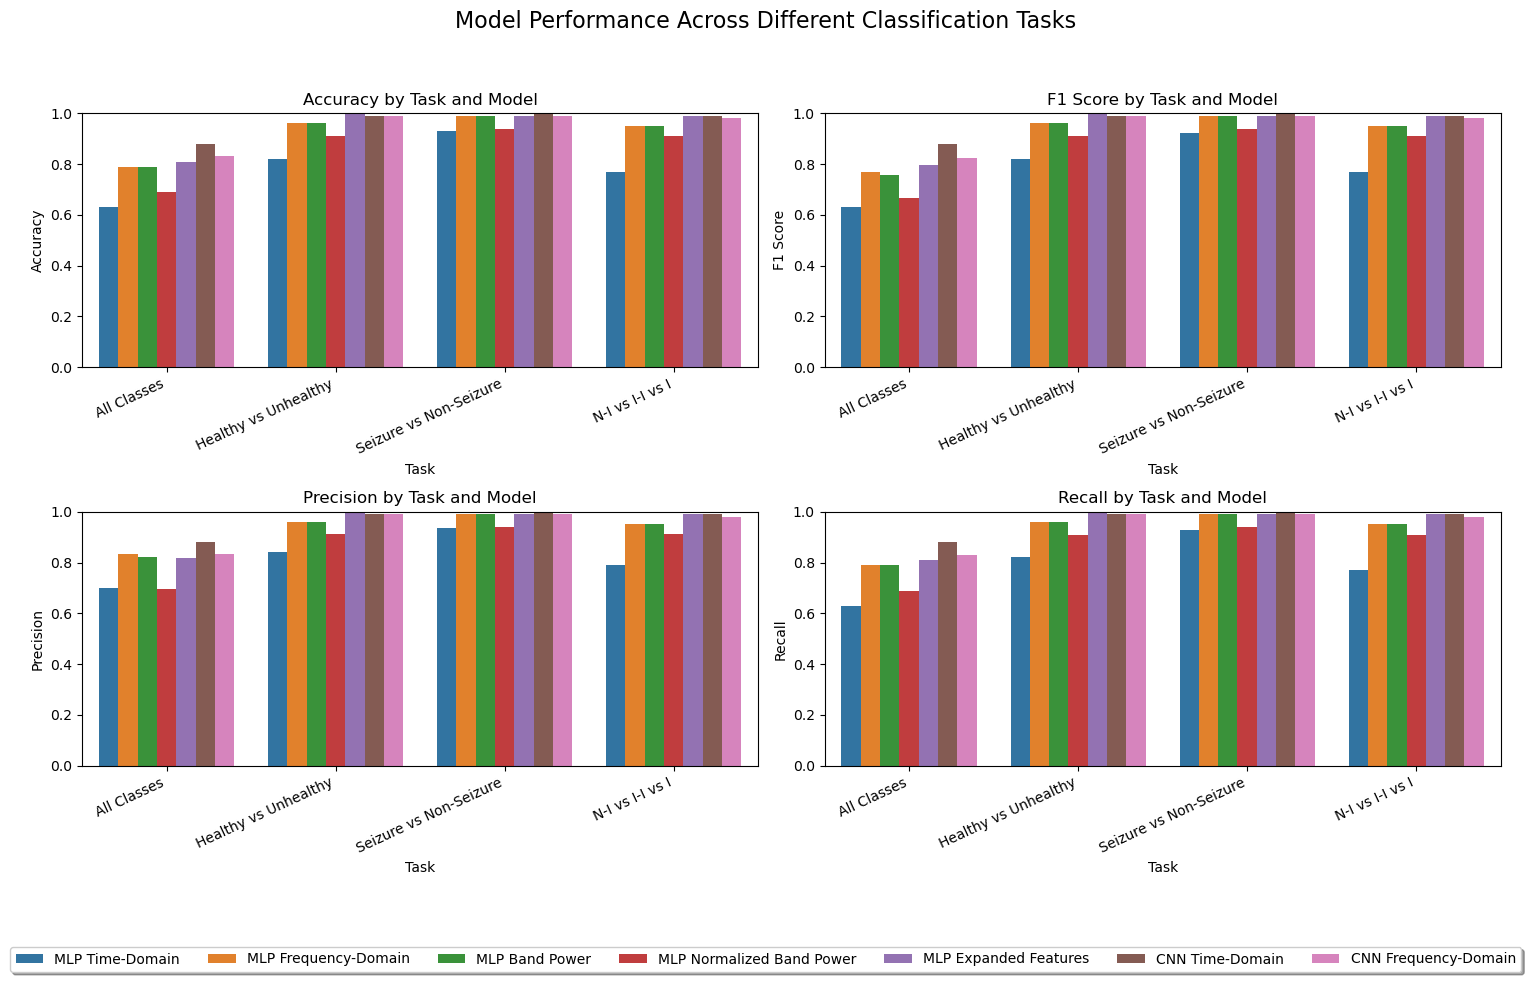

In [ ]:
# Visualizing the results with a single shared legend
plt.figure(figsize=(15, 10))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Plot accuracy comparison
sns.barplot(x="Task", y="Accuracy", hue="Model", data=results_df, ax=axes[0])
axes[0].set_title("Accuracy by Task and Model")
axes[0].set_ylim(0, 1)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25, ha='right')
axes[0].legend_.remove()  # Remove individual legend

# Plot F1 score comparison
sns.barplot(x="Task", y="F1 Score", hue="Model", data=results_df, ax=axes[1])
axes[1].set_title("F1 Score by Task and Model")
axes[1].set_ylim(0, 1)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25, ha='right')
axes[1].legend_.remove()  # Remove individual legend

# Plot precision comparison
sns.barplot(x="Task", y="Precision", hue="Model", data=results_df, ax=axes[2])
axes[2].set_title("Precision by Task and Model")
axes[2].set_ylim(0, 1)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=25, ha='right')
axes[2].legend_.remove()  # Remove individual legend

# Plot recall comparison
sns.barplot(x="Task", y="Recall", hue="Model", data=results_df, ax=axes[3])
axes[3].set_title("Recall by Task and Model")
axes[3].set_ylim(0, 1)
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=25, ha='right')
axes[3].legend_.remove()  # Remove individual legend

# Get handles and labels from any of the axes (they're the same for all)
handles, labels = axes[0].get_legend_handles_labels()

# Create a single legend outside the subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
           fancybox=True, shadow=True, ncol=len(labels))

plt.suptitle("Model Performance Across Different Classification Tasks", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to make room for the legend at the bottom
plt.show()

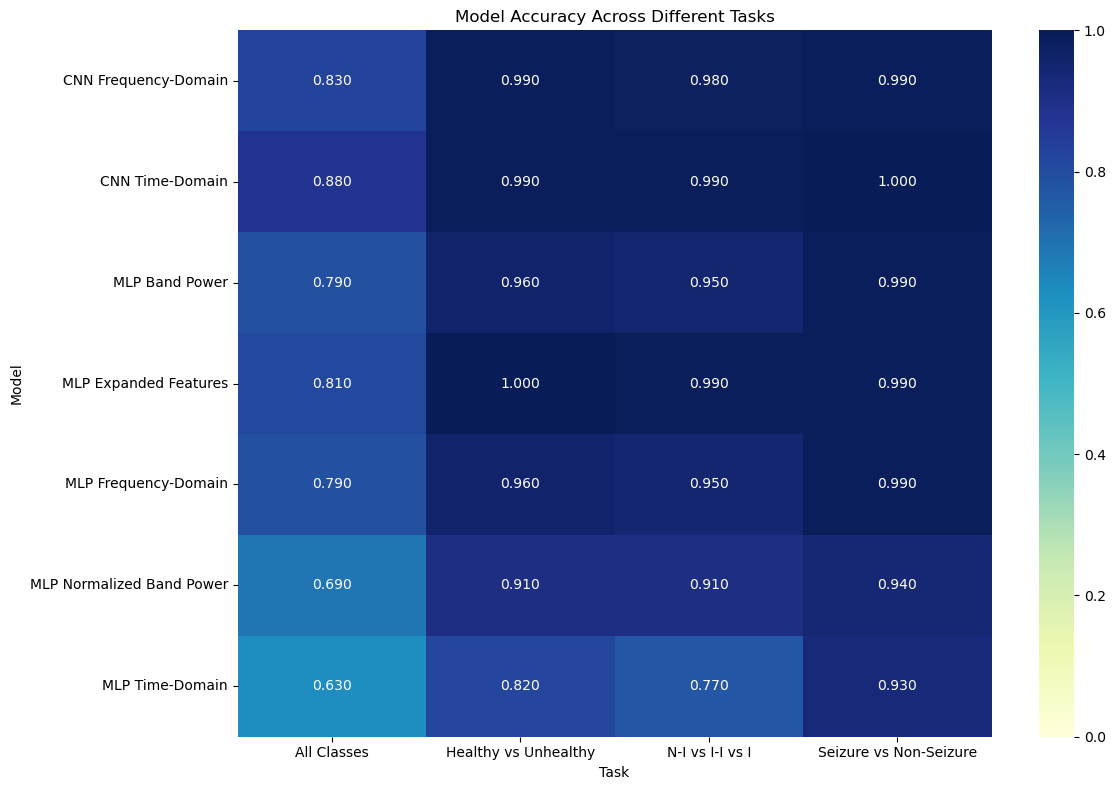

Model                    Task  \
0             MLP Time-Domain             All Classes   
1             MLP Time-Domain    Healthy vs Unhealthy   
2             MLP Time-Domain  Seizure vs Non-Seizure   
3             MLP Time-Domain         N-I vs I-I vs I   
4        MLP Frequency-Domain             All Classes   
5        MLP Frequency-Domain    Healthy vs Unhealthy   
6        MLP Frequency-Domain  Seizure vs Non-Seizure   
7        MLP Frequency-Domain         N-I vs I-I vs I   
8              MLP Band Power             All Classes   
9              MLP Band Power    Healthy vs Unhealthy   
10             MLP Band Power  Seizure vs Non-Seizure   
11             MLP Band Power         N-I vs I-I vs I   
12  MLP Normalized Band Power             All Classes   
13  MLP Normalized Band Power    Healthy vs Unhealthy   
14  MLP Normalized Band Power  Seizure vs Non-Seizure   
15  MLP Normalized Band Power         N-I vs I-I vs I   
16      MLP Expanded Features             All Classes   
17      MLP Expanded Features    Healthy vs Unhealthy   
18      MLP Expanded Features  Seizure vs Non-Seizure   
19      MLP Expanded Features         N-I vs I-I vs I   
20            CNN Time-Domain             All Classes   
21            CNN Time-Domain    Healthy vs Unhealthy   
22            CNN Time-Domain  Seizure vs Non-Seizure   
23            CNN Time-Domain         N-I vs I-I vs I   
24       CNN Frequency-Domain             All Classes   
25       CNN Frequency-Domain    Healthy vs Unhealthy   
26       CNN Frequency-Domain  Seizure vs Non-Seizure   
27       CNN Frequency-Domain         N-I vs I-I vs I   

                                     Task Description  Accuracy  F1 Score  \
0                                   All 5 EEG classes      0.63  0.629717   
1               Healthy (Z, O) vs Unhealthy (N, F, S)      0.82  0.821818   
2             Seizure (S) vs Non-Seizure (Z, O, N, F)      0.93  0.924043   
3   Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...      0.77  0.768485   
4                                   All 5 EEG classes      0.79  0.769977   
5               Healthy (Z, O) vs Unhealthy (N, F, S)      0.96  0.960000   
6             Seizure (S) vs Non-Seizure (Z, O, N, F)      0.99  0.989903   
7   Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...      0.95  0.950180   
8                                   All 5 EEG classes      0.79  0.757972   
9               Healthy (Z, O) vs Unhealthy (N, F, S)      0.96  0.960149   
10            Seizure (S) vs Non-Seizure (Z, O, N, F)      0.99  0.989903   
11  Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...      0.95  0.950043   
12                                  All 5 EEG classes      0.69  0.667074   
13              Healthy (Z, O) vs Unhealthy (N, F, S)      0.91  0.910473   
14            Seizure (S) vs Non-Seizure (Z, O, N, F)      0.94  0.938791   
15  Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...      0.91  0.909858   
16                                  All 5 EEG classes      0.81  0.797212   
17              Healthy (Z, O) vs Unhealthy (N, F, S)      1.00  1.000000   
18            Seizure (S) vs Non-Seizure (Z, O, N, F)      0.99  0.990091   
19  Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...      0.99  0.990059   
20                                  All 5 EEG classes      0.88  0.878558   
21              Healthy (Z, O) vs Unhealthy (N, F, S)      0.99  0.990020   
22            Seizure (S) vs Non-Seizure (Z, O, N, F)      1.00  1.000000   
23  Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...      0.99  0.989998   
24                                  All 5 EEG classes      0.83  0.823134   
25              Healthy (Z, O) vs Unhealthy (N, F, S)      0.99  0.990020   
26            Seizure (S) vs Non-Seizure (Z, O, N, F)      0.99  0.989903   
27  Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...      0.98  0.979934   

    Precision  Recall  
0    0.700833    0.63  
1    0.840000    0.82  
2    0.935632    0.93  
3    0.790703    0.77  
4    0.835238   


Best Models for Each Task:


Task                                   Task Description  \
20             All Classes                                  All 5 EEG classes   
17    Healthy vs Unhealthy              Healthy (Z, O) vs Unhealthy (N, F, S)   
19         N-I vs I-I vs I  Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...   
22  Seizure vs Non-Seizure            Seizure (S) vs Non-Seizure (Z, O, N, F)   

                    Model  Accuracy  F1 Score  
20        CNN Time-Domain      0.88  0.878558  
17  MLP Expanded Features      1.00  1.000000  
19  MLP Expanded Features      0.99  0.990059  
22        CNN Time-Domain      1.00  1.000000

In [ ]:
# Create a heatmap for accuracy across models and tasks
plt.figure(figsize=(12, 8))
heatmap_data = results_df.pivot(index="Model", columns="Task", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".3f")
plt.title("Model Accuracy Across Different Tasks")
plt.tight_layout()
plt.show()

# Display the complete results table
display(results_df)

# Summary of best models for each task
best_models = results_df.loc[results_df.groupby("Task")["Accuracy"].idxmax()]
print("\nBest Models for Each Task:")
display(best_models[["Task", "Task Description", "Model", "Accuracy", "F1 Score"]])